# Objetivos del proyecto.

Vamos a analizar un conjunto de datos de la Universidad de Wisconsin, que contiene información sobre pacientes con posible cáncer de mama, junto con su clasificación (diagnóstico positivo o negativo).

Nuestro objetivo será entrenar y comparar diversos modelos de conjunto (ensemble models) para evaluar su desempeño.

Dado que este es un problema de diagnóstico médico, priorizaremos la métrica de recall de la clase positiva ('Malignant'), definida como: $$Recall_{Malignant}=\frac{True positives}{True positives + False Negatives},$$ ya que tiene más importancia detectar todos los posibles casos de cancer aunque esto nos lleve a dar algún falso positivo. Esta métrica se suele llamar sensibilidad en un contexto estadístico clásico.

_Es importante notar que en la práctica clínica moderna, el sobrediagnóstico del cáncer de mama es un tema muy importante. Detectar un cáncer que nunca habría causado síntomas o problemas en la vida de la paciente puede llevar a tratamientos innecesarios. De hecho, el sobrediagnóstico es actualmente uno de los principales inconvenientes de la práctica extendida de mamografías. Para más información, véase el artículo:  https://pmc.ncbi.nlm.nih.gov/articles/PMC5365181/#:~:text=Overdiagnosis%20(overdetection)%20of%20BC%20from,side%20of%20population%20breast%20screening._

En este proyecto, no solo nos interesa la precisión del modelo con respecto a métricas estándar, sino que también es fundamental evaluar su interpretabilidad. En sectores como la salud (y en áreas financieras como la concesión de préstamos hipotecarios), es indispensable entender por qué un modelo toma ciertas decisiones. Para lograrlo, utilizaremos la técnica de **Shapley Values**, que permite explicar la contribución de cada variable en las predicciones. Además, exploraremos otras técnicas complementarias para mejorar el análisis de las decisiones del modelo.

# Paquetes

En esta sección simplemente cargaremos todos los paquetes necesarios para llevar a cabo el análisis.

In [1]:
# Load libraries

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier

import umap


from auxiliary_functions import (
    violin_plotter, 
    swarm_plotter, 
    get_feature_importances, 
    evaluate_models, 
    evaluate_multiple_models, 
    multiple_cross_val_confusions, 
    cross_val_confusion,
    perform_random_search,
    evaluate_final_model
)



import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

# Cargando y explicando el dataset

A continuación cargamos el dataset y sus metadatos para analizarlo.

In [2]:
from ucimlrepo import fetch_ucirepo 
  

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

print(breast_cancer_wisconsin_diagnostic.metadata) 
   
print(breast_cancer_wisconsin_diagnostic.variables) 

df = pd.concat([X, y], axis=1)
df['Diagnosis']=df['Diagnosis'].map({'M': 1, 'B': 0})

ConnectionError: Error connecting to server

El repositorio se encontraba fuera de servicio durante los últimos días de realización, afortunadamente tenía un train-test split guardado. Vamos a usar esos datos para completar la practica.

In [3]:
target='Diagnosis'
df_train=pd.read_csv('df_train.csv')
df_test=pd.read_csv('df_test.csv')
df=pd.concat([df_train,df_test], axis=0)

y_train=df_train[target]
y_test=df_test[target]

mean_columns = [col for col in df_train.columns if col.endswith('_mean')]
se_columns = [col for col in df_train.columns if col.endswith('_se')]
worst_columns = [col for col in df_train.columns if col.endswith('_worst')]
features=mean_columns+se_columns+worst_columns

Puesto que los metadatos no contienen demasiada información, vamos a explicar un poco las caracterisitcas de este conjunto de datos. Los detalles que se presentan a continuación pueden encontrarse en:https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

# Conjunto de Datos: Breast Cancer Wisconsin (Diagnostic)

El conjunto de datos **Breast Cancer Wisconsin (Diagnostic)** contiene información derivada de imágenes digitalizadas de aspiraciones con aguja fina (**FNA**) de masas mamarias.  
Cada instancia representa características de los núcleos celulares presentes en la imagen.

## Columnas del Conjunto de Datos

### Identificación y Diagnóstico
- **ID**: Número de identificación del paciente.
- **Diagnóstico**: Clasificación del tumor, donde **"M"** indica maligno y **"B"** indica benigno.

### Características de los Núcleos Celulares
Para cada núcleo celular, se calcularon **10 características reales**:

1. **Radio**: Promedio de las distancias desde el centro hasta los puntos en el perímetro.
2. **Textura**: Desviación estándar de los valores de escala de grises.
3. **Perímetro**: Longitud del perímetro del núcleo.
4. **Área**: Área del núcleo.
5. **Suavidad**: Variación local en las longitudes del radio.
6. **Compacidad**: $ \text{Perímetro}^2 / \text{Área} - 1.0 .$
7. **Concavidad**: Severidad de las porciones cóncavas del contorno.
8. **Puntos cóncavos**: Número de porciones cóncavas del contorno.
9. **Simetría**: Simetría del núcleo.
10. **Dimensión fractal**: "Aproximación de la línea de costa" - 1.

### Valores Calculados para Cada Característica
Para cada una de estas 10 características, se calcularon **tres valores**:

- **Media**: Valor promedio de la característica.  
- **Error estándar**: Desviación estándar de la característica.  
- **Peor valor**: Mayor valor observado (promedio de los tres valores más grandes).  

Esto da lugar a un total de **30 columnas de características** en el conjunto de datos.

### Ejemplo de Columnas en el Dataset

| Tipo | Radio | Textura | Perímetro |
|------|-------|---------|-----------|
| **Media** | `radius_mean` | `texture_mean` | `perimeter_mean` |
| **Error estándar** | `radius_se` | `texture_se` | `perimeter_se` |
| **Peor valor** | `radius_worst` | `texture_worst` | `perimeter_worst` |

Y así sucesivamente para las demás características.

Puesto que queda mucho más claro tener los nombres con _mean _se y _worst en lugar de 1 2 y 3, los sustituimos a continuación.


In [4]:
df.columns = df.columns.str.replace('1', '_mean').str.replace('2', '_se').str.replace('3', '_worst')
print(df.shape)
df.head()


(569, 31)


radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        15.34         14.26          102.50      704.4          0.10730   
1        13.94         13.17           90.31      594.2          0.12480   
2        13.90         16.62           88.97      599.4          0.06828   
3        14.25         22.15           96.42      645.7          0.10490   
4        14.47         24.99           95.81      656.4          0.08837   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.21350         0.20770              0.09756         0.2521   
1           0.09755         0.10100              0.06615         0.1976   
2           0.05319         0.02224              0.01339         0.1813   
3           0.20080         0.21350              0.08653         0.1949   
4           0.12300         0.10090              0.03890         0.1872   

   fractal_dimension_mean  ...  texture_worst  perimeter_worst  area_worst  \
0                 0.07032  ...          19.08           125.10       980.9   
1                 0.06457  ...          15.38            94.52       653.3   
2                 0.05536  ...          21.80           101.20       718.9   
3                 0.07292  ...          29.51           119.10       959.5   
4                 0.06341  ...          31.73           113.50       808.9   

   smoothness_worst  compactness_worst  concavity_worst  concave_points_worst  \
0           0.13900             0.5954           0.6305               0.23930   
1           0.13940             0.1364           0.1559               0.10150   
2           0.09384             0.2006           0.1384               0.06222   
3           0.16400             0.6247           0.6922               0.17850   
4           0.13400             0.4202           0.4040               0.12050   

   symmetry_worst  fractal_dimension_worst  Diagnosis  
0          0.4667                  0.09946          1  
1          0.2160                  0.07253          0  
2          0.2679                  0.07698          0  
3          0.2844                  0.11320          1  
4          0.3187                  0.10230          0  

[5 rows x 31 columns]

Vamos también a guardar los subconjuntos de columnas en variables para usarlas durante el resto del proyecto.

In [5]:
mean_columns = [col for col in df.columns if col.endswith('_mean')]
se_columns = [col for col in df.columns if col.endswith('_se')]
worst_columns = [col for col in df.columns if col.endswith('_worst')]
features=mean_columns+se_columns+worst_columns

target='Diagnosis'

# Fase preprocesado

## Estadistica basica

In [6]:
pd.set_option('display.precision', 3)
df.describe()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
count      569.000       569.000         569.000    569.000          569.000   
mean        14.127        19.290          91.969    654.889            0.096   
std          3.524         4.301          24.299    351.914            0.014   
min          6.981         9.710          43.790    143.500            0.053   
25%         11.700        16.170          75.170    420.300            0.086   
50%         13.370        18.840          86.240    551.100            0.096   
75%         15.780        21.800         104.100    782.700            0.105   
max         28.110        39.280         188.500   2501.000            0.163   

       compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
count           569.000         569.000              569.000        569.000   
mean              0.104           0.089                0.049          0.181   
std               0.053           0.080                0.039          0.027   
min               0.019           0.000                0.000          0.106   
25%               0.065           0.030                0.020          0.162   
50%               0.093           0.062                0.034          0.179   
75%               0.130           0.131                0.074          0.196   
max               0.345           0.427                0.201          0.304   

       fractal_dimension_mean  ...  texture_worst  perimeter_worst  \
count                 569.000  ...        569.000          569.000   
mean                    0.063  ...         25.677          107.261   
std                     0.007  ...          6.146           33.603   
min                     0.050  ...         12.020           50.410   
25%                     0.058  ...         21.080           84.110   
50%                     0.062  ...         25.410           97.660   
75%                     0.066  ...         29.720          125.400   
max                     0.097  ...         49.540          251.200   

       area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count     569.000           569.000            569.000          569.000   
mean      880.583             0.132              0.254            0.272   
std       569.357             0.023              0.157            0.209   
min       185.200             0.071              0.027            0.000   
25%       515.300             0.117              0.147            0.115   
50%       686.500             0.131              0.212            0.227   
75%      1084.000             0.146              0.339            0.383   
max      4254.000             0.223              1.058            1.252   

       concave_points_worst  symmetry_worst  fractal_dimension_worst  \
count               569.000         569.000                  569.000   
mean                  0.115           0.290                    0.084   
std                   0.066           0.062                    0.018   
min                   0.000           0.157                    0.055   
25%                   0.065           0.250                    0.071   
50%                   0.100           0.282                    0.080   
75%                   0.161           0.318                    0.092   
max                   0.291           0.664                    0.207   

       Diagnosis  
count    569.000  
mean       0.373  
std        0.484  
min        0.000  
25%        0.000  
50%        0.000  
75%        1.000  
max        1.000  

[8 rows x 31 columns]

In [7]:
# class distribution
df.groupby('Diagnosis').size()

Diagnosis
0    357
1    212
dtype: int64

### train test split

Vamos a dividir nuestro conjunto de datos en entrenamiento y test antes de la visualización y análisis exploratorio. Aunque podríamos hacerlo después, he decidido hacerlo en este punto porque utilizaré las visualizaciones y el análisis de correlaciones para una selección preliminar de variables. Al hacerlo antes, evitamos el data leakage, es decir, la contaminación del conjunto de entrenamiento con información del test, lo que garantizará que cualquier insight obtenido provenga únicamente de los datos con los que entrenaremos el modelo.

Dado que, según la descripción de los datos, es probable que existan altas correlaciones entre muchas variables, este análisis debe realizarse con el apoyo de un experto en el dominio (en este caso, un oncólogo especializado en cáncer de mama). La razón es que, aunque algunas características estén altamente correlacionadas, pueden capturar matices clínicos distintos que queramos preservar. Además, en ciertos casos, conservar variables redundantes puede ser útil para mejorar la robustez del modelo frente a la pérdida de datos. Un ejemplo clásico es la medición de la presión arterial: si tenemos la presión arterial sistólica (PAS), la diastólica (PAD) y la presión de pulso (PAS - PAD), eliminar una de ellas por alta correlación podría hacer que el modelo sea menos resiliente si alguna medición estuviera ausente o fuera errónea.

Si bien la presencia de correlaciones no afecta el poder predictivo de los modelos que utilizaremos, sí influye en su interpretabilidad. En particular, en algoritmos como los bosques aleatorios, la importancia de las variables (feature importance) puede verse distorsionada, ya que el modelo tiende a seleccionar aleatoriamente una de entre varias características altamente correlacionadas, subestimando la relevancia real de estas variables.

Por todas estas razones, optamos por realizar la división antes del análisis exploratorio. Esto nos permitirá trabajar con una muestra representativa del conjunto de entrenamiento y garantizar que cualquier selección de variables o transformación realizada se base exclusivamente en los datos disponibles para el entrenamiento del modelo, evitando sesgos y fugas de información.

In [8]:
""" X_train, X_test, y_train, y_test= train_test_split(df[features],df[target],test_size=0.2)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1) """

' X_train, X_test, y_train, y_test= train_test_split(df[features],df[target],test_size=0.2)\ndf_train = pd.concat([X_train, y_train], axis=1)\ndf_test = pd.concat([X_test, y_test], axis=1) '

El código arriba se encuentra comentado puesto que ya tenia el split guardado y el repositorio se encontraba caido. Nótese que no usamos el parámetro `stratify`, esto es una decisión consciente.

El uso de estratificación durante la división de datos tiene ventajas en muchos casos, especialmente cuando se busca preservar la proporción de clases en conjuntos de entrenamiento y prueba. Sin embargo, en este proyecto se ha optado por **no utilizar estratificación** basándonos en varios argumentos fundamentados:

1. **Asunción del modelo sobre la distribución de las clases:**  
   Muchos modelos de Machine Learning realizan suposiciones implícitas o explícitas sobre la distribución de las clases o las características. Si se utiliza estratificación, se fuerza al modelo a aprender con la misma proporción de clases que existe en el conjunto de datos original. Esto puede ser problemático si dicha proporción está sesgada o no refleja adecuadamente el entorno real al que se desea aplicar el modelo. Por ejemplo, en campos médicos es común tener conjuntos de datos con más ejemplos negativos que positivos debido a la naturaleza del problema o al método de muestreo.

2. **Sesgo en el conjunto de datos:**  
   En el caso del conjunto de datos de cáncer de mama de Wisconsin (Wisconsin Breast Cancer Dataset), este fue recopilado hace más de 25 años. La proporción de benignos y malignos ha cambiado significativamente desde entonces. Si se aplica estratificación basada en esta proporción antigua, se perpetúa un sesgo que puede llevar a un rendimiento poco fiable o no generalizable en situaciones actuales.  

3. **Generalización fuera de la muestra:**  
   El objetivo principal del entrenamiento de un modelo de aprendizaje automático es que pueda generalizar adecuadamente a nuevos conjuntos de datos. Si se utiliza estratificación durante la validación cruzada, cada uno de los subconjuntos de validación tendrá aproximadamente la misma proporción de clases que el conjunto original. Esto puede llevar a que el modelo o la selección de hiperparámetros se adapte demasiado a esta distribución específica, en lugar de aprender a generalizar en situaciones con proporciones diferentes.

4. **Mayor robustez frente a variaciones de distribución:**  
   Al no aplicar estratificación, cada partición generada durante la validación cruzada puede tener proporciones ligeramente diferentes de las clases. Este enfoque introduce aleatoriedad que, si bien puede aumentar ligeramente la varianza en las métricas de rendimiento, también fomenta la **robustez del modelo** frente a distribuciones no vistas. Esto es especialmente relevante si se espera que el modelo se aplique a escenarios con proporciones de clases distintas a las del conjunto de datos original.

5. **Validación cruzada y evaluación final:**  
   Si bien se ha utilizado validación cruzada para la selección de hiperparámetros, se ha mantenido un conjunto de prueba independiente sin estratificación para la evaluación final. Este conjunto permite evaluar el rendimiento del modelo en un escenario más realista y libre de sesgos inducidos por la proporción histórica de clases.

In [9]:
scaler= StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[features]), columns=features, index=df_train.index) 
X_test_scaled = pd.DataFrame(scaler.transform(df_test[features]), columns=features, index=df_test.index)  


# Reconstruct scaled df_train
df_train_scaled = pd.concat([X_train_scaled, y_train], axis=1)
df_test_scaled= pd.concat([X_test_scaled, y_test], axis=1)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


## Visualización

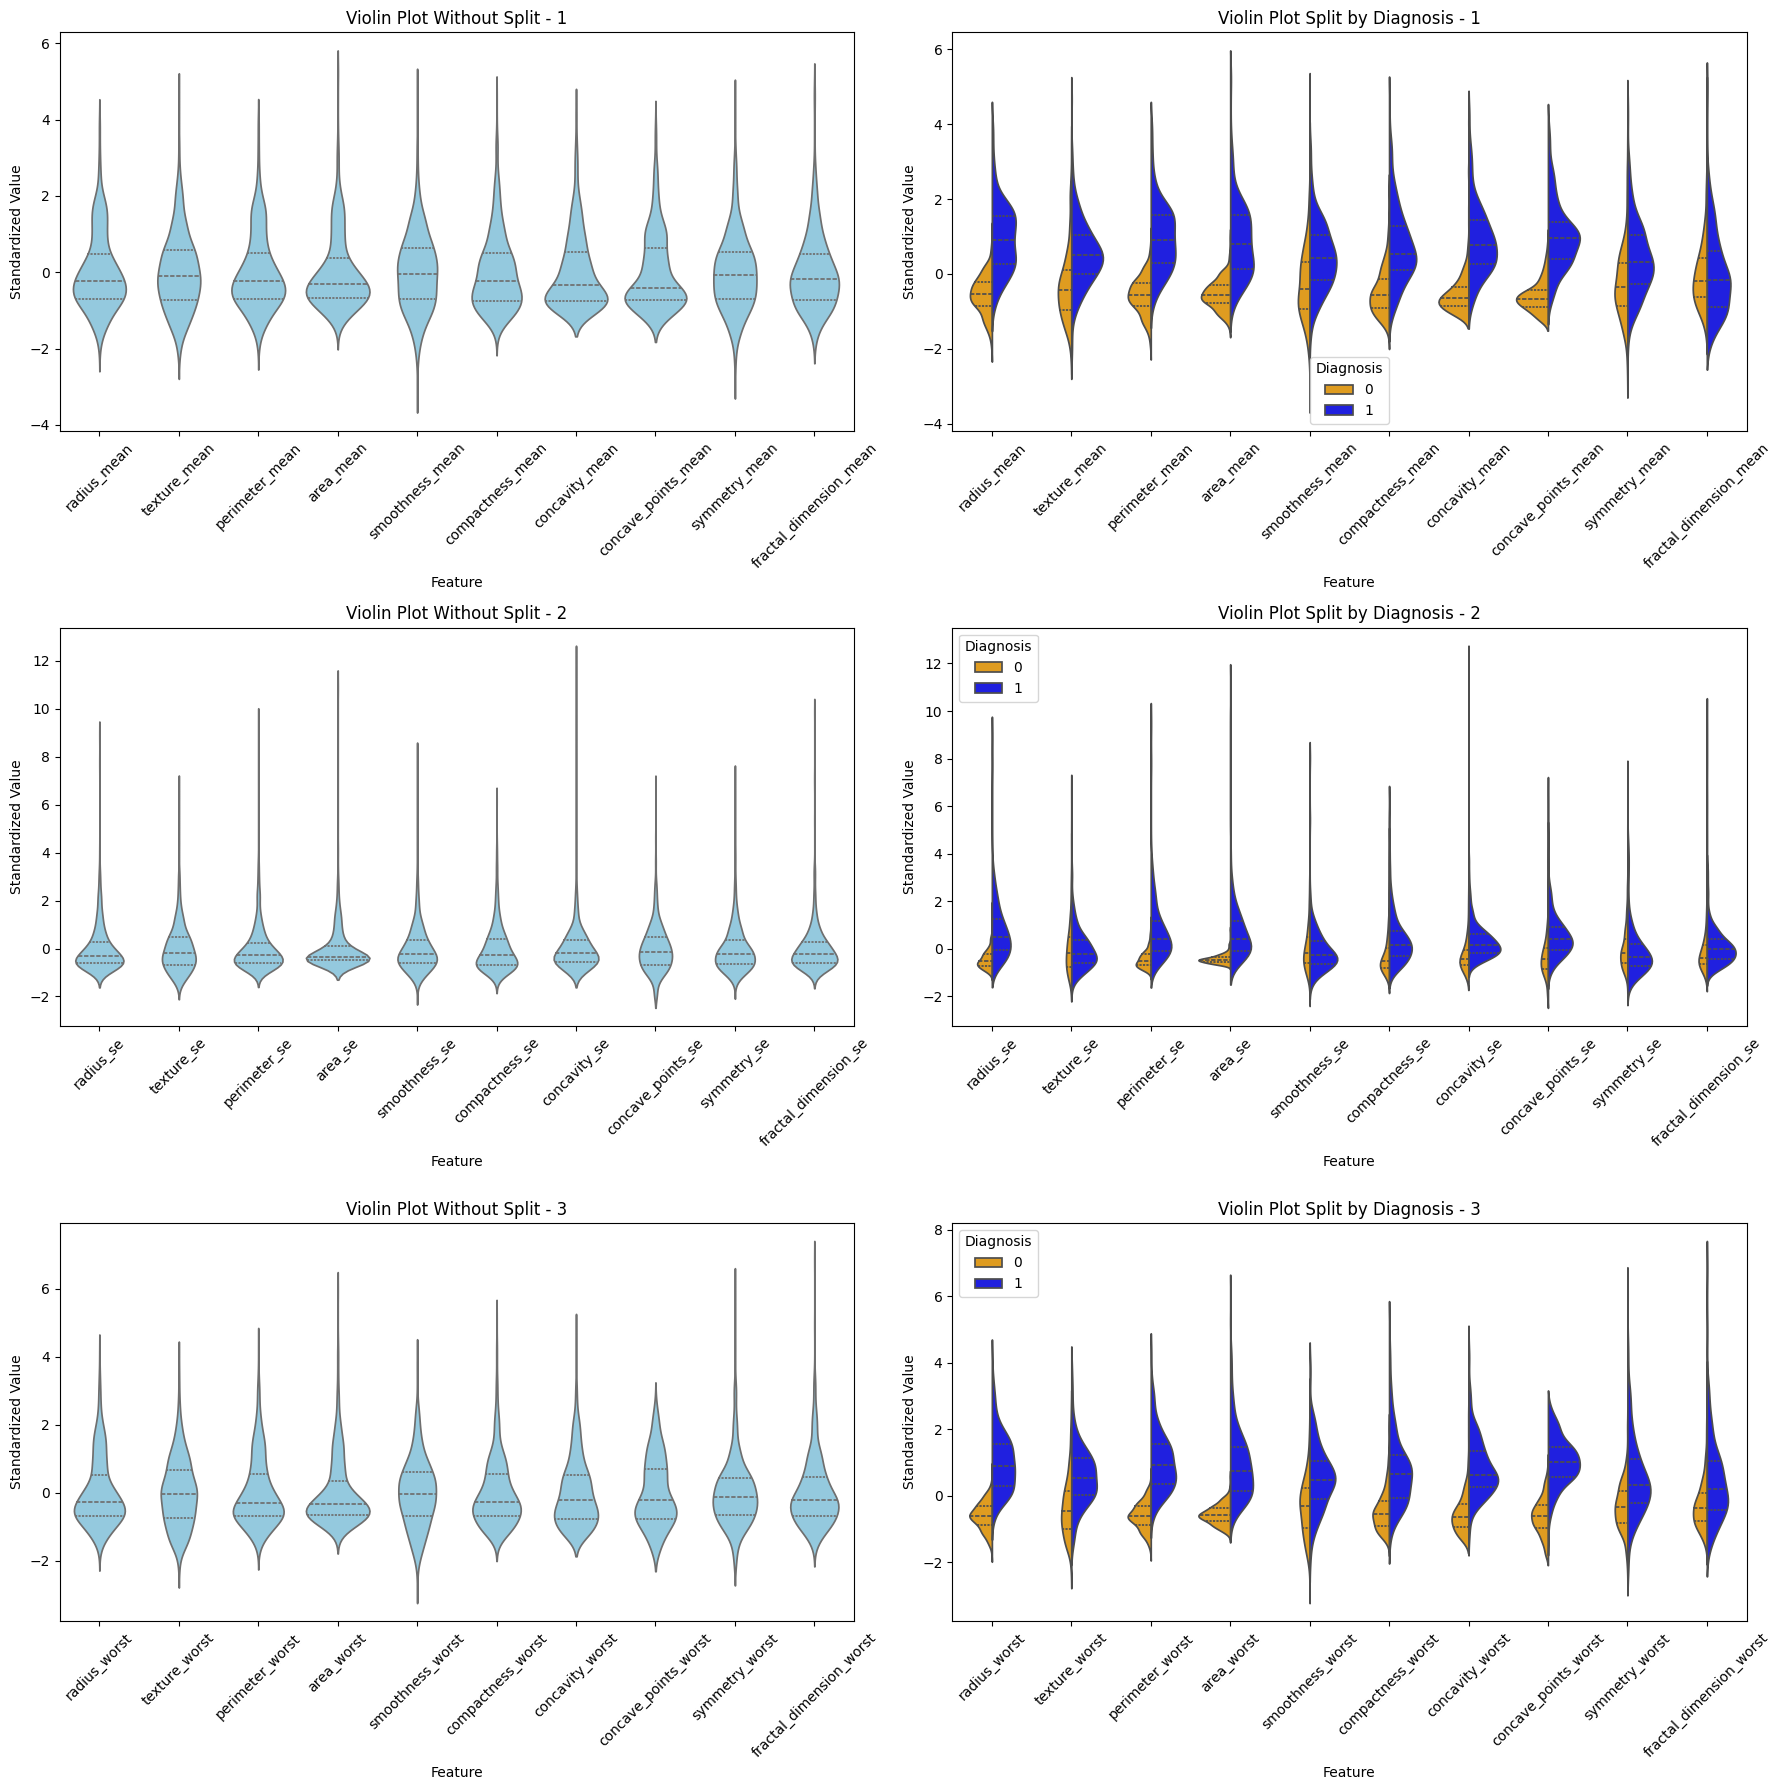

In [10]:
palette = {1: "blue", 0: "orange"}


fig, axes = plt.subplots(3, 2, figsize=(18, 18)) 

# List of feature sets for each row (customize as needed)
feature_groups = [
    mean_columns,  # Row 1, Left: Mean Features
    se_columns,    # Row 2, Left: SE Features
    worst_columns  # Row 3, Left: Worst Features
]

for i, ax_row in enumerate(axes):

    violin_plotter(df, feature_groups[i], ax=ax_row[0])
    ax_row[0].set_title(f"Violin Plot Without Split - {i+1}")

    violin_plotter(df, feature_groups[i], split_column="Diagnosis", palette=palette, ax=ax_row[1])
    ax_row[1].set_title(f"Violin Plot Split by Diagnosis - {i+1}")


plt.tight_layout()
plt.show()


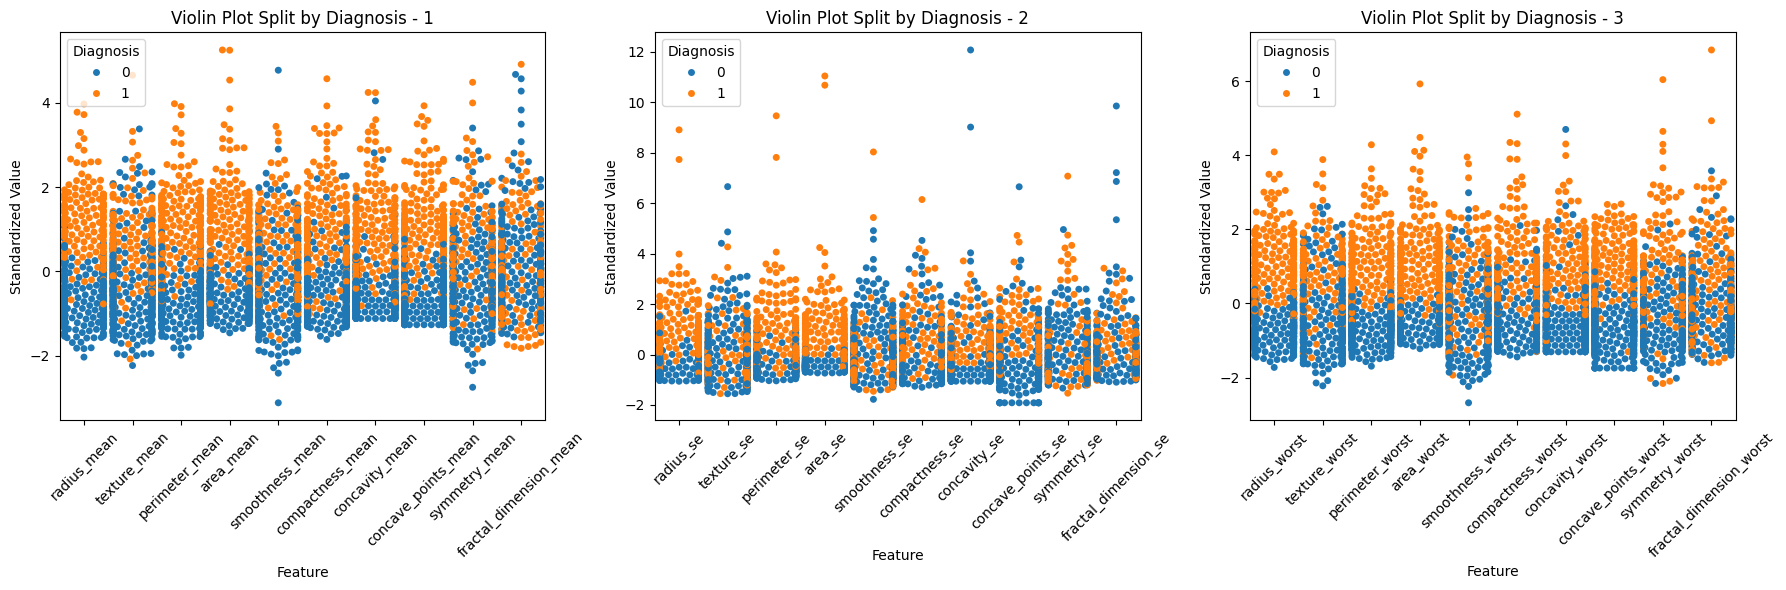

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusté la altura también

feature_groups = [
    mean_columns,
    se_columns,
    worst_columns
]

for i, ax in enumerate(axes):
    swarm_plotter(df, feature_groups[i], split_column="Diagnosis", ax=ax, palette=sns.color_palette() )
    ax.set_title(f"Violin Plot Split by Diagnosis - {i+1}")

plt.tight_layout()
plt.show() 

## Correlaciones

Vamos a echar un vistazo a las correlaciones entre variables. Simplemente por los nombres de las variables ya podemos esperar correlaciones altas, pero debemos confirmar nuestras sospechas.

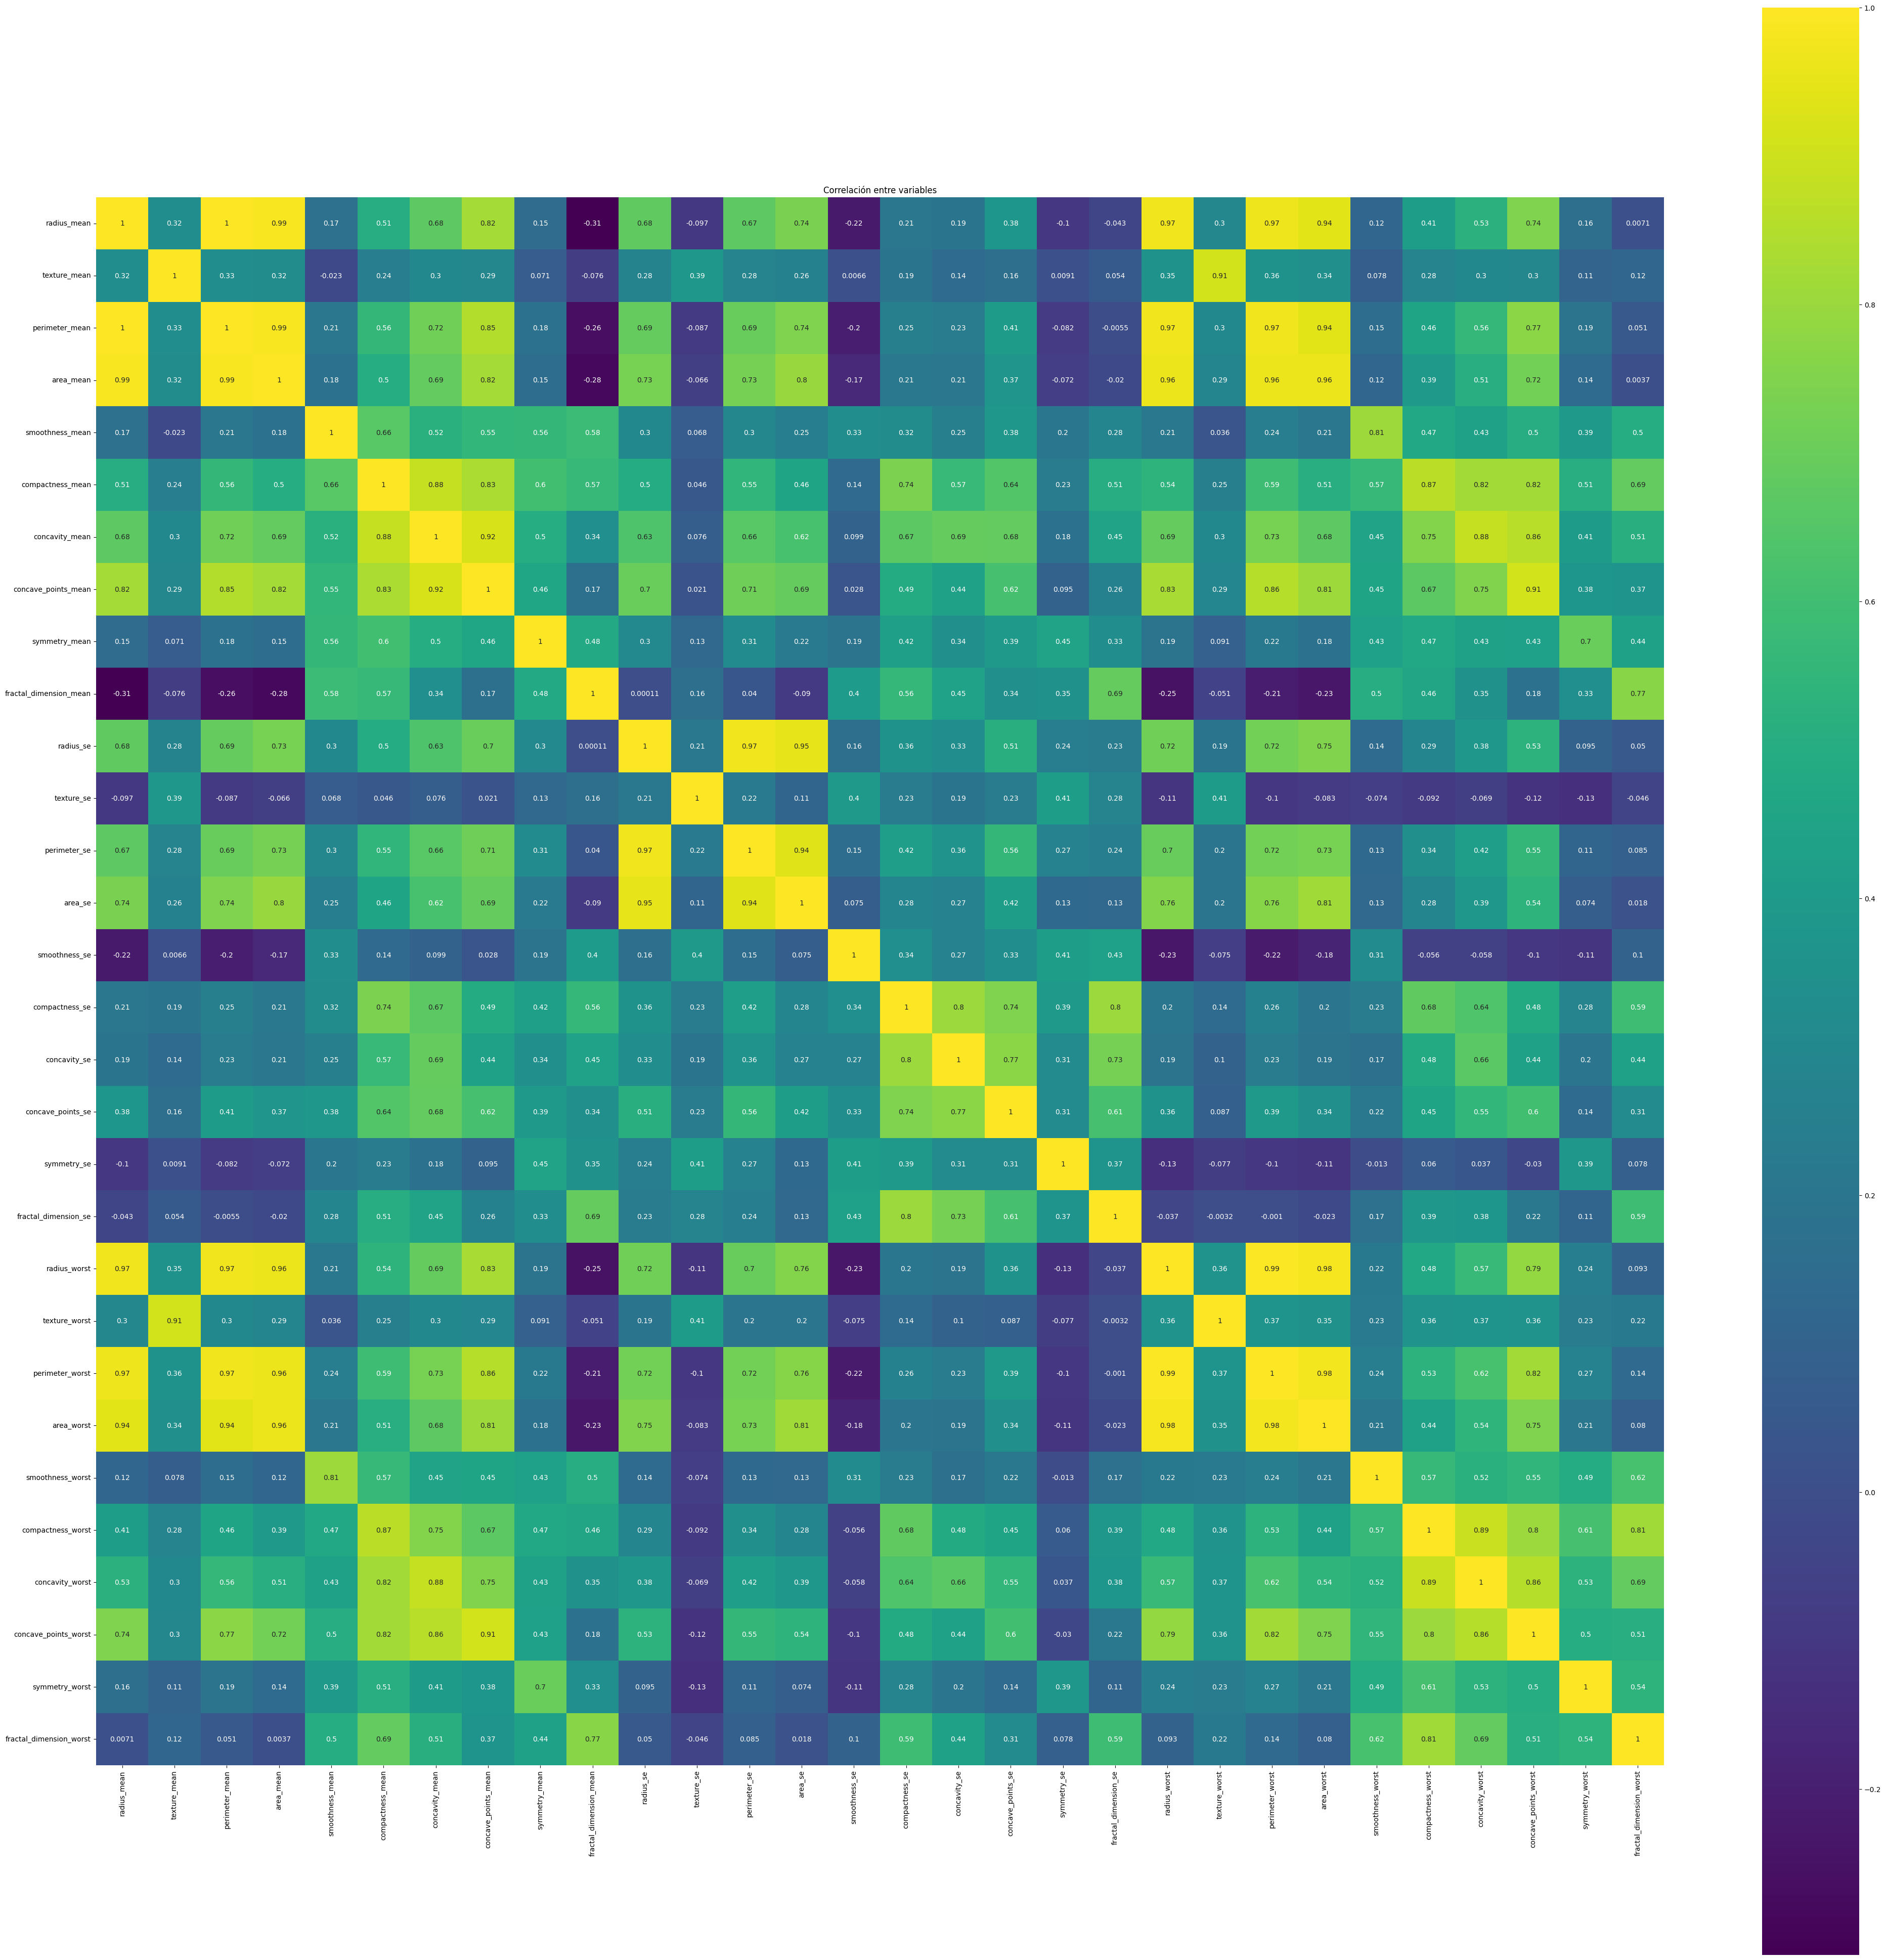

In [12]:
correlation = df[features].corr()
plt.figure(figsize=(50,50))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre variables')
plt.show()

Como esperábamos, tenemos bloques altamente correlacionados:

- **Bloque 1**:
  - `radius_mean`
  - `perimeter_mean`
  - `area_mean`

- **Bloque 2**:
  - `compactness_mean`
  - `concavity_mean`
  - `concave_points_mean`

- **Bloque 3**:
  - `radius_se`
  - `perimeter_se`
  - `area_se`

- **Bloque 4**:
  - `compactness_se`
  - `concavity_se`
  - `concave_points_se`

- **Bloque 5**:
  - `radius_worst`
  - `perimeter_worst`
  - `area_worst`

- **Bloque 6**:
  - `compactness_worst`
  - `concavity_worst`
  - `concave_points_worst`

También tenemos **alta correlación entre los bloques 1 y 5**.


Vamos a guardar estos bloques en un diccionario para poder hacer más visualizaciones.

In [13]:
corr_blocks = {
    "block_mean_area": ["radius_mean", "perimeter_mean", "area_mean"],
    "block_mean_concav": ["compactness_mean", "concavity_mean", "concave_points_mean"],
    "block_se_area": ["radius_se", "perimeter_se", "area_se"],
    "block_se_concav": ["compactness_se", "concavity_se", "concave_points_se"],
    "block_worst_area": ["radius_worst", "perimeter_worst", "area_worst"],
    "block_worst_compact": ["compactness_worst", "concavity_worst", "concave_points_worst"],
}

A continuación presentamos unas gráficas donde en la diagonal vemos la densidad de la variable (dibujada con un KDE), en la mitad superior de la matriz vemos un scatter plot de una variable contra la otra y en la mitad interior un KDE de las dos variables conjuntas para hacernos una idea de su distribución.

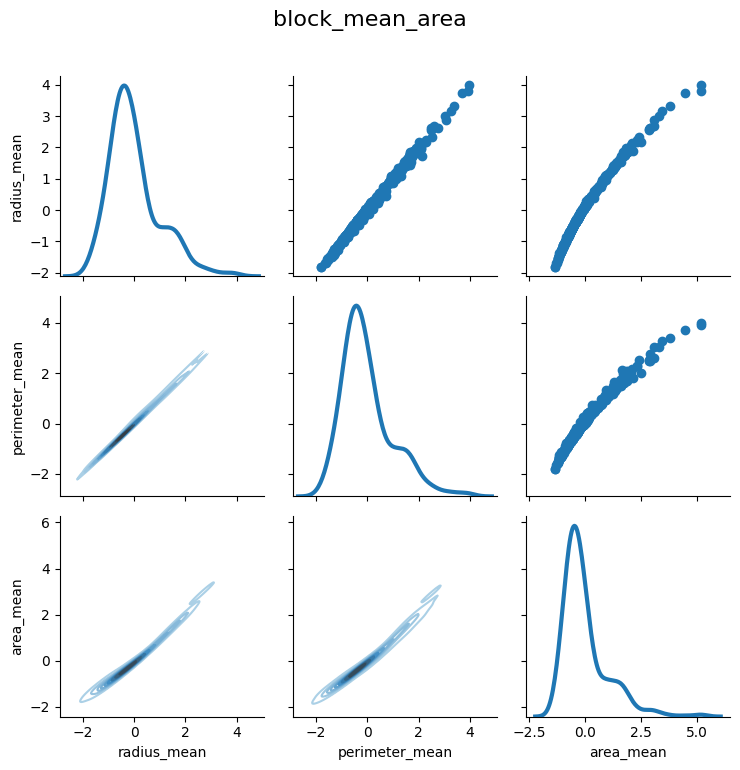

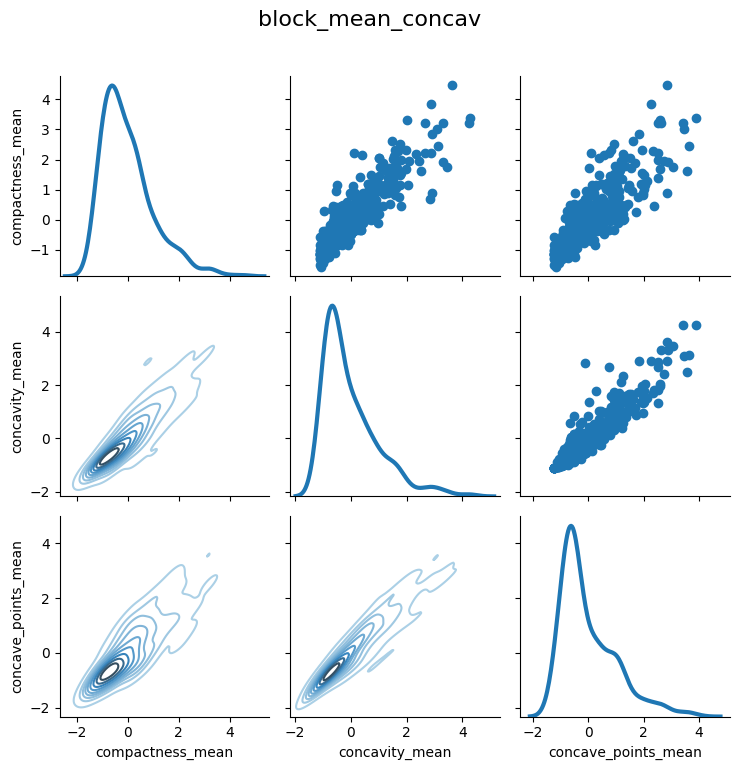

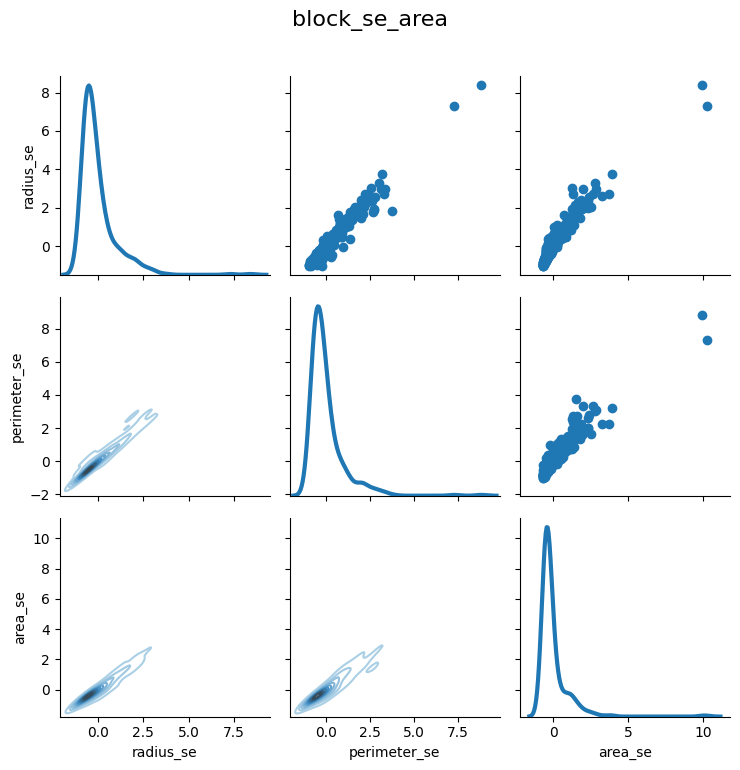

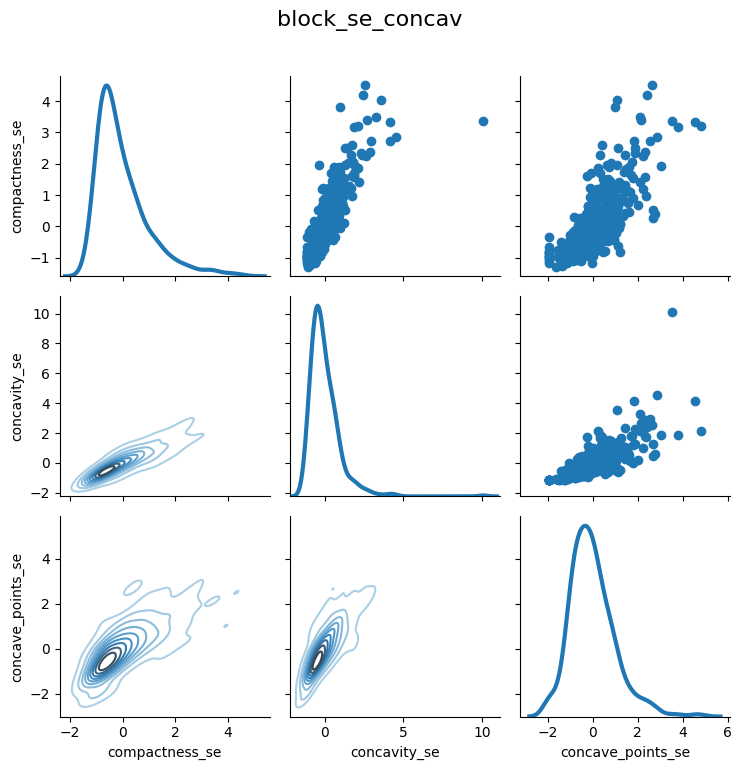

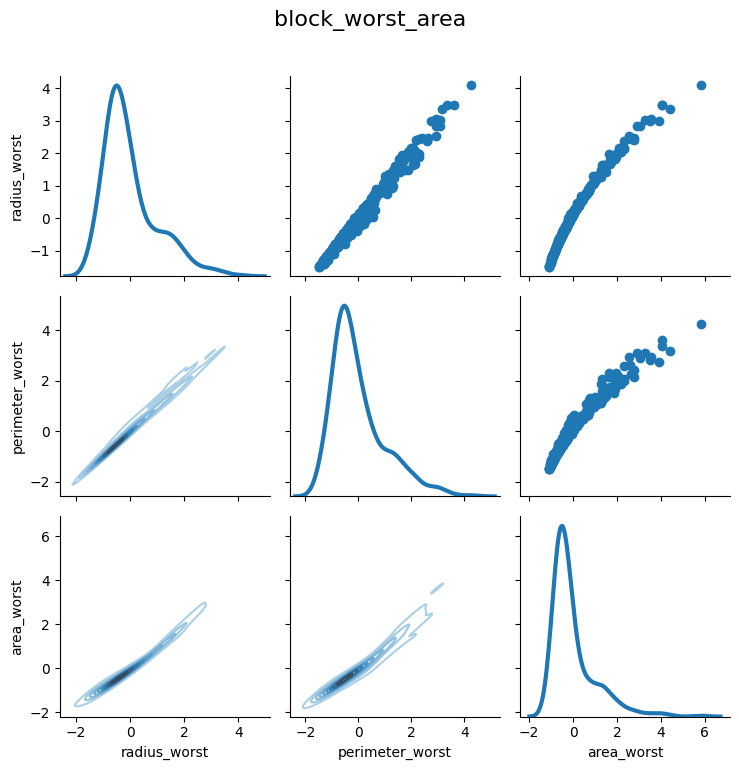

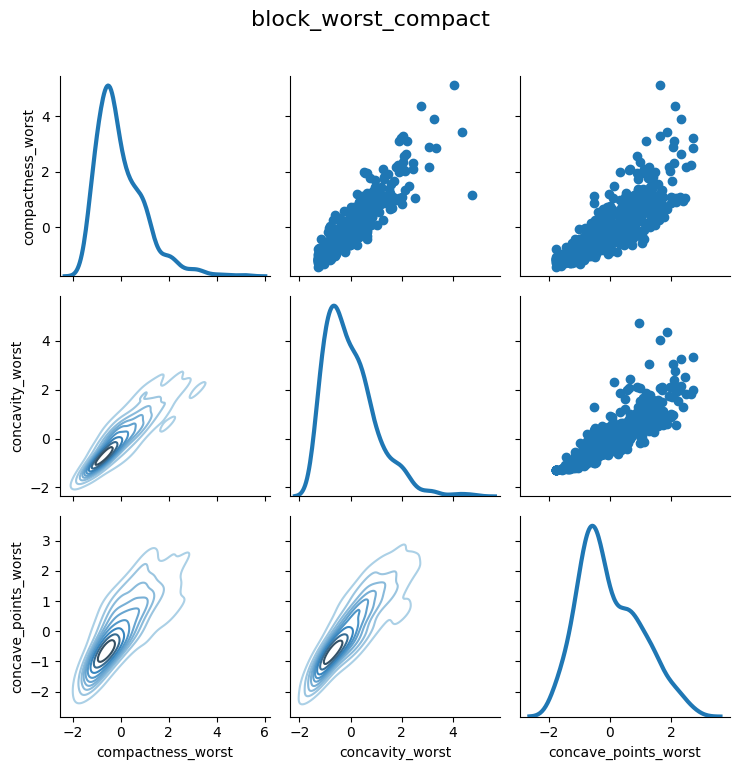

In [14]:
for block_name, features_corr in corr_blocks.items():
    g = sns.PairGrid(df_train_scaled[features_corr], diag_sharey=False)
    g.map_lower(sns.kdeplot, cmap="Blues_d")
    g.map_upper(plt.scatter)
    g.map_diag(sns.kdeplot, lw=3)
    g.fig.suptitle(block_name, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


Esto nos permite confirmar con más certeza que las altas correlaciones no son casos de distribuciones patológicas si no que son variables altamente colineales.

A continuación selecciono una variable de cada uno de los bloques de alta correlación, para ello utilizo las gráficas de violín y enjambre presentadas anteriormente. De cada bloque elijo la que parece presentar mejor separación entre casos de tumores benignos y malignos.

In [15]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave_points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave_points_worst','compactness_se','concave_points_se','texture_worst']
df_train_scaled_filtered = df_train_scaled.drop(drop_list1,axis = 1 ) 
df_train_scaled_filtered.head()


texture_mean  area_mean  smoothness_mean  concavity_mean  symmetry_mean  \
0        -1.123      0.141            0.792           1.512          2.575   
1        -1.370     -0.169            2.020           0.173          0.598   
2        -0.588     -0.154           -1.947          -0.814          0.007   
3         0.664     -0.024            0.623           1.584          0.500   
4         1.307      0.006           -0.537           0.172          0.221   

   fractal_dimension_mean  texture_se  area_se  smoothness_se  concavity_se  \
0                   1.069      -0.887    0.080         -0.087         1.228   
1                   0.242       2.528    0.076          0.955         0.606   
2                  -1.082      -1.123   -0.553         -1.204        -0.789   
3                   1.443       0.104    0.405          0.752         1.396   
4                   0.075      -0.231   -0.367          0.024         0.260   

   symmetry_se  fractal_dimension_se  area_worst  smoothness_worst  \
0        1.961                 0.227       0.175             0.317   
1       -0.416                 0.672      -0.390             0.335   
2       -0.901                -0.677      -0.277            -1.669   
3       -0.435                 0.903       0.138             1.417   
4        0.012                 0.902      -0.122             0.097   

   concavity_worst  symmetry_worst  fractal_dimension_worst  Diagnosis  
0            1.755           3.016                    0.861          1  
1           -0.537          -1.245                   -0.640          0  
2           -0.621          -0.363                   -0.392          0  
3            2.053          -0.083                    1.627          1  
4            0.661           0.500                    1.020          0

In [16]:
filtered_features = [f for f in features if f not in drop_list1]

A continuación vemos la matriz de correlaciones de las variables que hemos dejado para proceder con el análisis. Se puede ver una gran mejoría, aunque aún siguen quedando algunas variables con alta correlación.

He decidido no seguir seleccionando variables solamente con la correlación porque a continuación aplicaremos otros métodos.

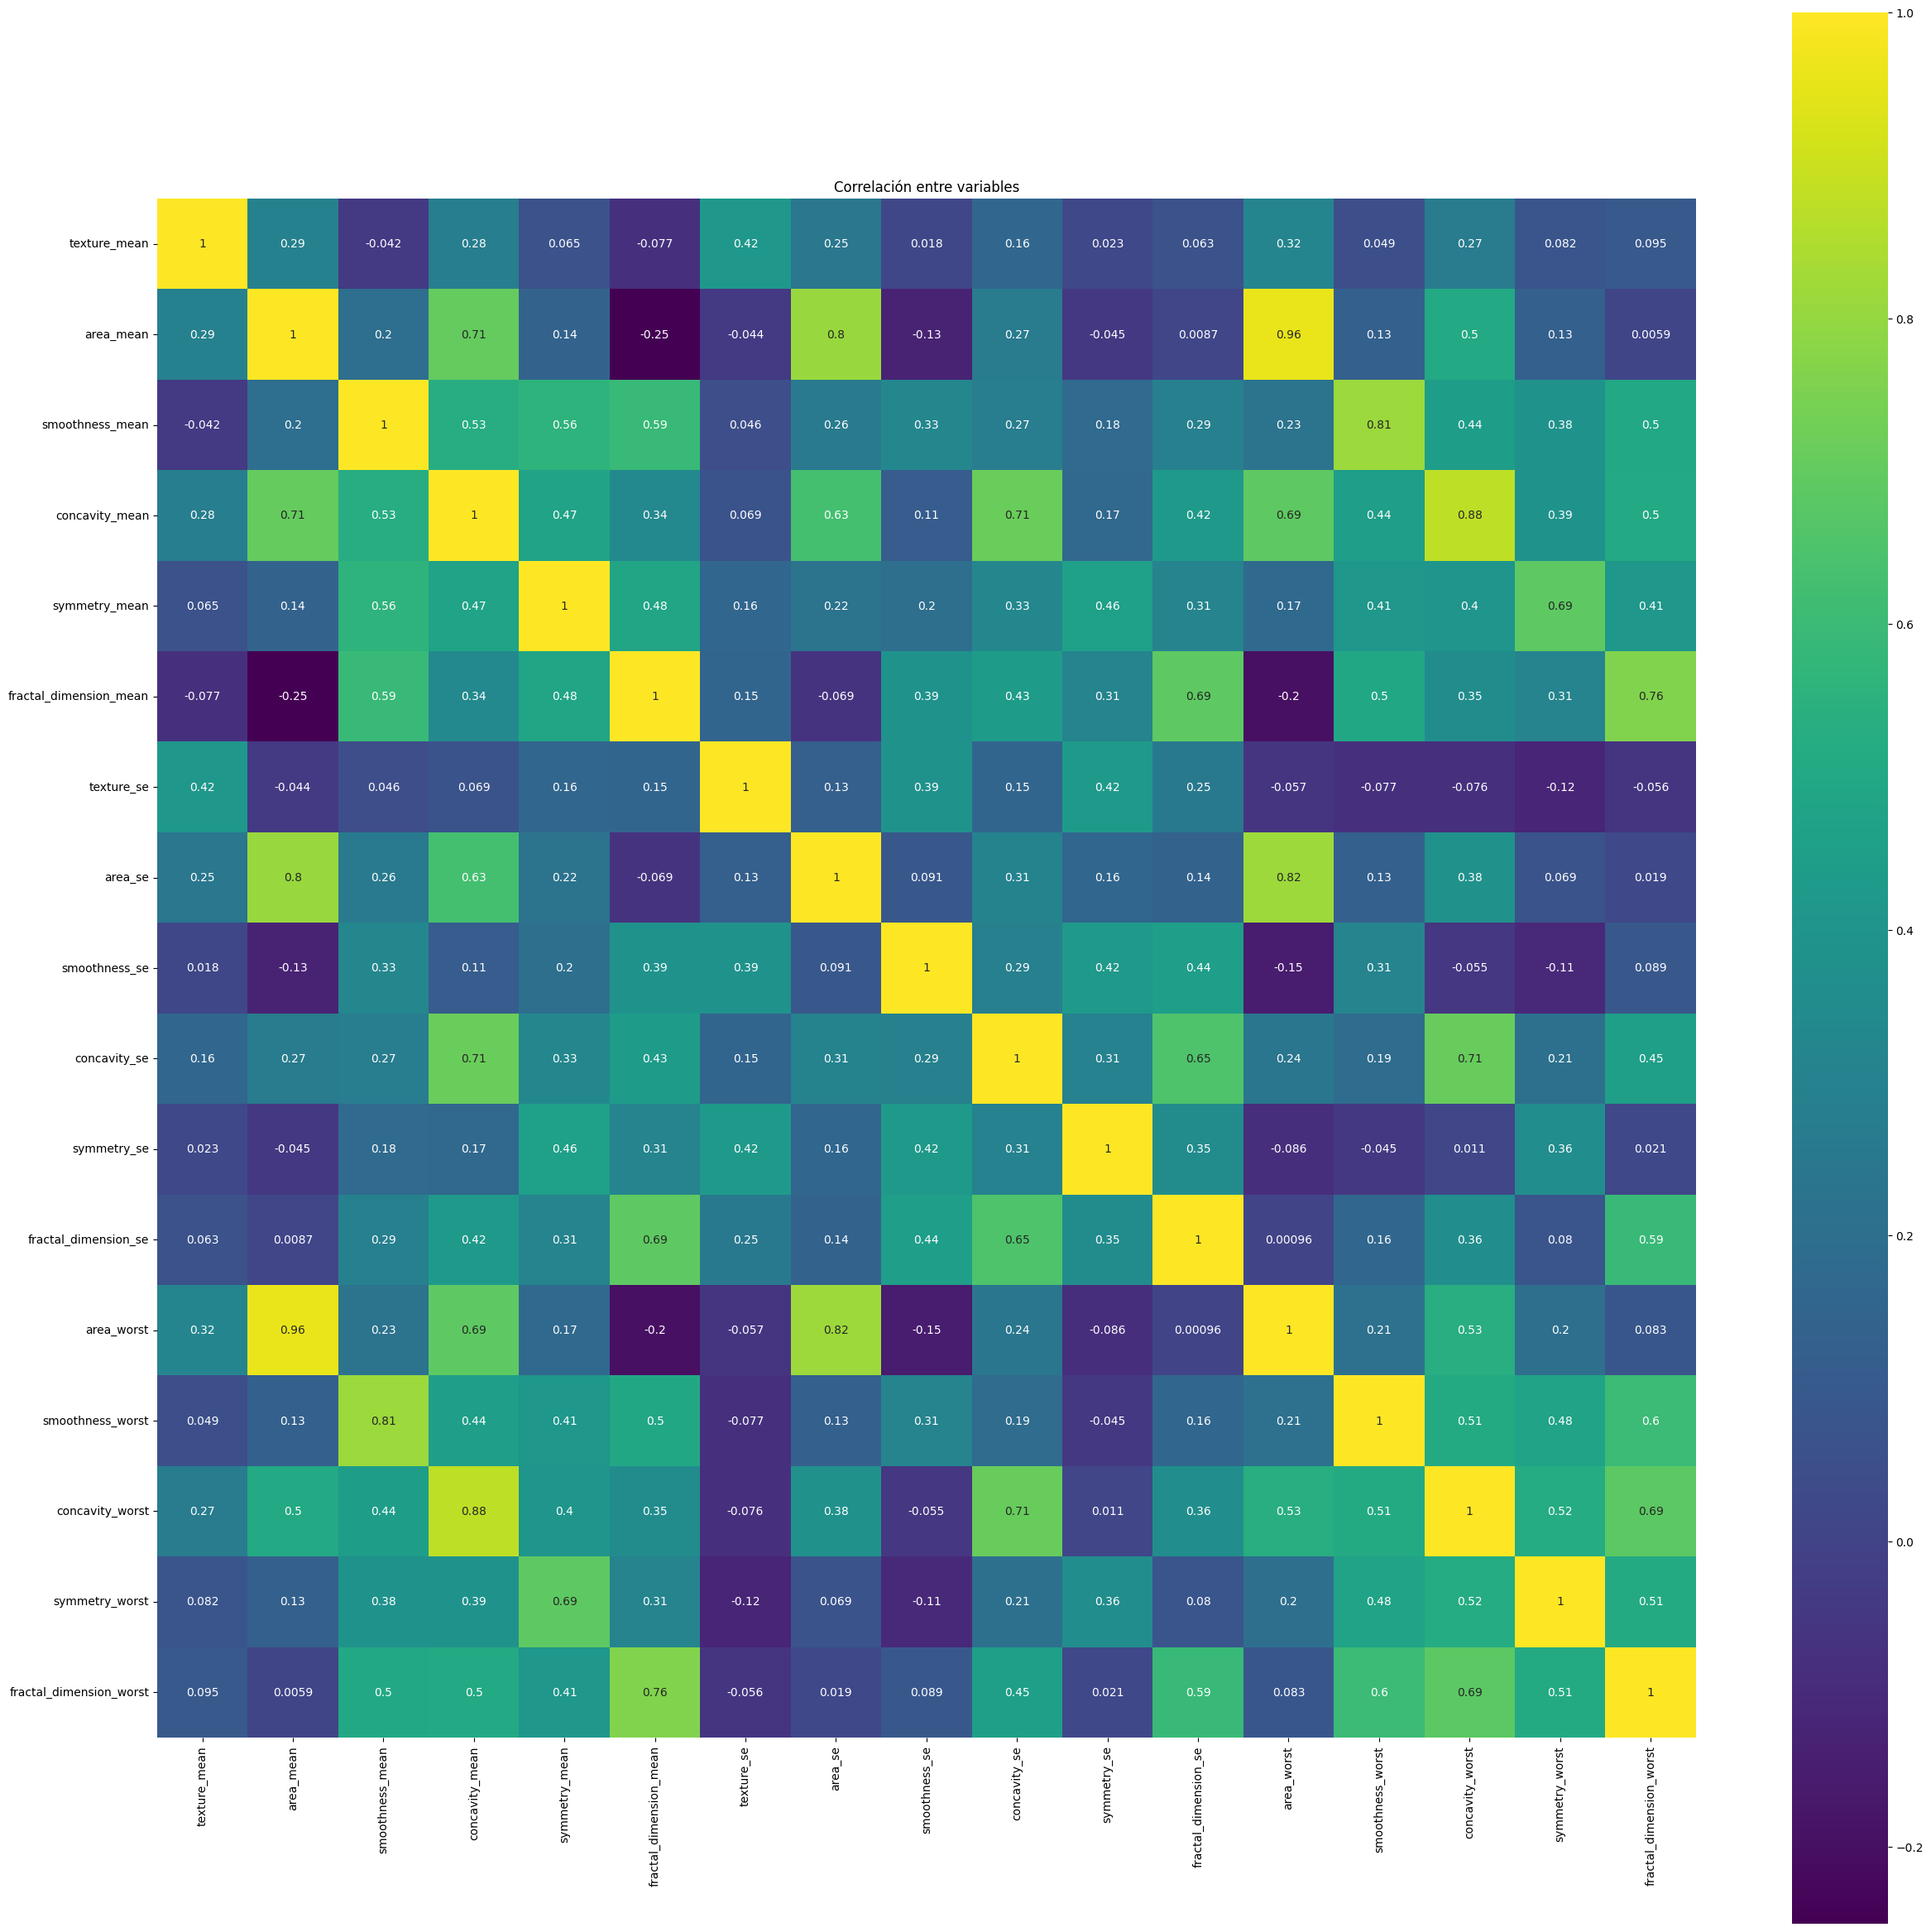

In [17]:
correlation =df_train_scaled[filtered_features].corr()
plt.figure(figsize=(30,30))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre variables')
plt.show()

## Feature importance

In [18]:
X_train=df_train_scaled[features]
y_train=df_train_scaled[target]

X_train_filtered=df_train_scaled[filtered_features]
y_train_filtered=df_train_scaled[target]

Hemos llevado a cabo una preselección de variables usando simplemente las correlaciones. Uno de los objetivos de esta preselección era poder usar `feature_importances` de los bosques aleatorios. Este método nos permite averiguar que características son importantes para distinguir los casos benignos y malignos ajustando un bosque aleatorio a los datos  y viendo que características aparecen más frecuentemente en la construcción de los distintos árboles. Una frecuencia de aparición alta quiere decir que es una característica que normalmente presenta el mejor umbral de corte para distinguir entre casos positivos y negativos.

Este método puede verse afectado por la colinealidad, puesto que si dos características son colineales o altamente correladas, ambas representarán umbrales esencialmente equivalentes, por lo que podemos esperar que el algoritmo de bosques aleatorios escoja una de ellas con probabilidad uniforme (si hay dos, probabilidad $\frac{1}{2}$, si hay $n$ variables altamente colineales por pares, probabilidad aproximadamente $\frac{1}{n}$). Lo cual daría una importancia aparente mucho más baja a las variables que la que en realidad les corresponde.

Vamos a ver esto ejemplificado a continuación. Mostramos a la izquierda la media y la desviación típica (en forma de barra de error) de extraer `feature_importances` de 100 random forest, cada uno con 500 árboles, sobre e conjunto de datos de entrenamiento con todas las variables. A la derecha podemos observar lo mismo pero esta vez sobre el conjunto de datos de entrenamiento donde hemos eliminado las variables altamente correlacionadas.

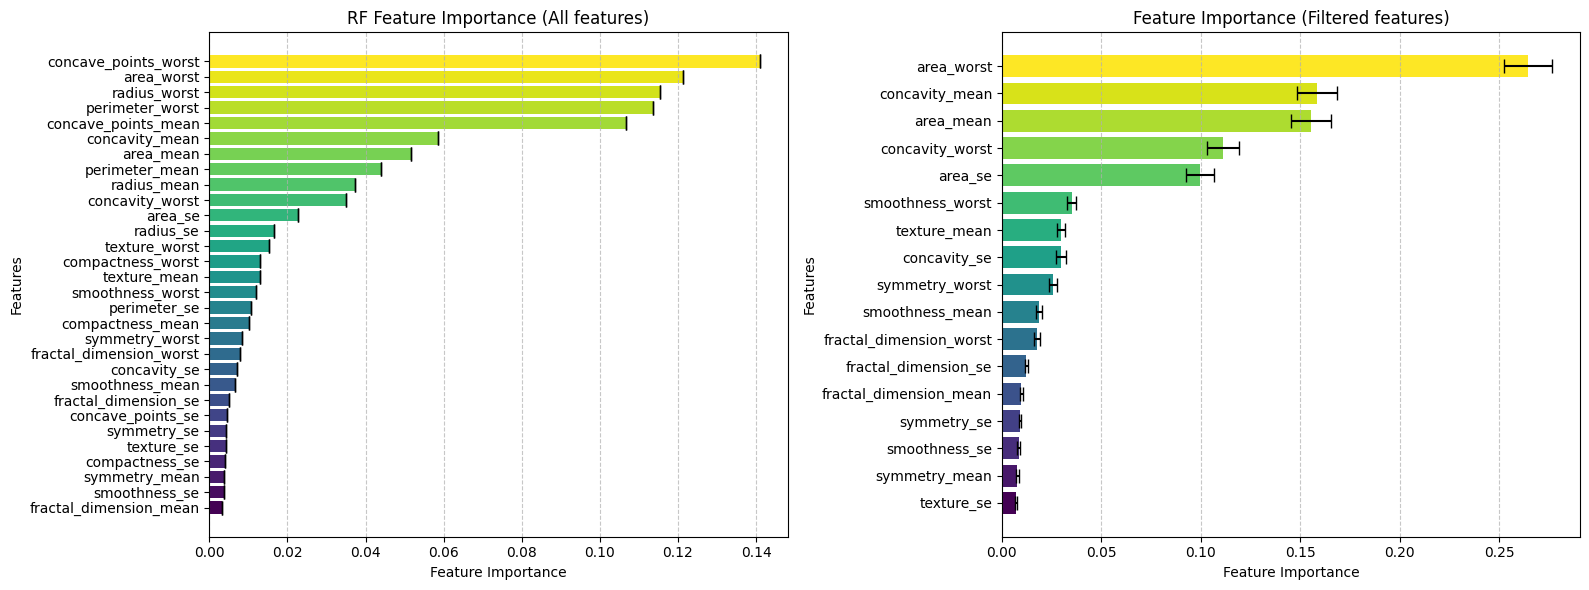

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_feat_imp_unfiltered, _, _ = get_feature_importances(X_train, y_train, 500, n_runs=1, ax=axes[0])
axes[0].set_title("RF Feature Importance (All features)")

df_feat_imp_filtered, _, _ = get_feature_importances(X_train_filtered, y_train_filtered, 500, n_runs=100, ax=axes[1])
axes[1].set_title("Feature Importance (Filtered features)")

plt.tight_layout()
plt.show()


Podemos ver que area worst gana mucho más protagonismo cuando hemos hecho un primer filtrado de las variables, en particular parece haber absorbido la importancia de `perimeter_worst` que es una de las variables que presentaba alta correlación con ella. 

A continuación vamos a quedarnos con las 11 variables más importantes (del conjunto filtrado) y con las 5 más importantes. Veremos el desempeño de los modelos en esos conjuntos para ver cuantas variables nos interesa retener. Posiblemente, un mayor número de variables de un mejor desempeño en todas las métricas (simplemente porque le proporcionamos más información al modelo), pero un menor numero de variables mejora la explicabilidad, por lo que quizás sea interesante sacrificar algo de desempeño. Esta decisión debería tomarse con expertos del área, pero desafortunadamente para este trabajo tendremos que intentar tomar estas decisiones solo con intuición.

In [20]:
top_11_imp_features = df_feat_imp_filtered.sort_values(by="Importance", ascending=False).head(11)["Feature"].tolist()
top_5_imp_features = df_feat_imp_filtered.sort_values(by="Importance", ascending=False).head(5)["Feature"].tolist()

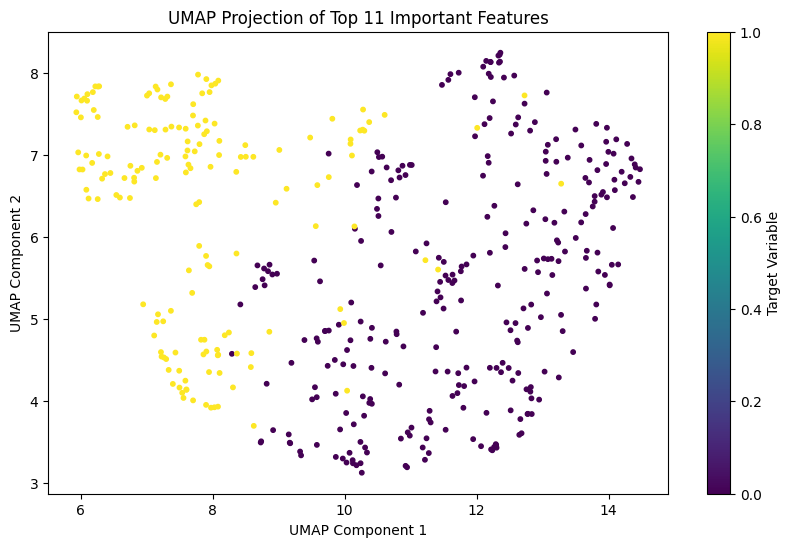

In [21]:
X_train_filtered_top11=df_train_scaled[top_11_imp_features]
y_train_filtered_top11=df_train_scaled[target]

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data to 2D
X_train_umap = reducer.fit_transform(X_train_filtered_top11)

# Plot the 2D projection with colors based on the target variable
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train_filtered_top11, cmap='viridis', s=10)
plt.colorbar(scatter, label='Target Variable')
plt.title('UMAP Projection of Top 11 Important Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


# Model training

A continuación vamos a proceder a entrenar los modelos y comprobar su desempeño usando validación cruzada. Vamos a dividir los modelos en varias categorías:

- **Voting**: Vamos a entrenar el mismo modelo (regresión logística, random forest y SVC) con dos esquemas
    - Soft: Hacemos la media de las probabilidades antes de decidir.
    - Hard: Tomamos la decisión mayoritaria.
- **Bagging**
- **Random forest y Extra trees**
- **Boosting**
- **Stacking**

Envaluaremos cada uno de estos modelos usando validación cruzada y diversas métricas. En cada subsección de esta parte, podemos ver los resultados de cada modelo, pero para facilitar la comparación, al final de la sección se muestra una recopilación de las métricas y matrices de confusión de cada modelo.

In [22]:
X_train=df_train_scaled[features]
y_train=df_train_scaled[target]

X_train_filtered=df_train_scaled[filtered_features]
y_train_filtered=df_train_scaled[target]


X_train_filtered_top11=df_train_scaled[top_11_imp_features]
y_train_filtered_top11=df_train_scaled[target]

X_train_filtered_top5=df_train_scaled[top_5_imp_features]
y_train_filtered_top5=df_train_scaled[target]

In [23]:
datasets = {
    "All Features": (X_train, y_train),
    "Filtered Features": (X_train_filtered, y_train_filtered),
    "Top 11 Important": (X_train_filtered_top11, y_train_filtered_top11),
    "Top 5 Important": (X_train_filtered_top5, y_train_filtered_top5)
}

# Definimos una metrica personalizada, el recall de la clase 'Malignant'.
malignant_recall = make_scorer(recall_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall_macro': 'recall_macro',
    'malignant_recall': malignant_recall
}


## Voting

Como dijimos al comienzo de la sección, vamos a tomar modelos de voto 'soft' y 'hard'. Es decir, media de probabilidades versus voto mayoritario.  

In [24]:
voting_soft = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)

results_df=evaluate_models(voting_soft, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.978         0.017              0.974   
1  Filtered Features          0.978         0.014              0.975   
2   Top 11 Important          0.976         0.015              0.971   
3    Top 5 Important          0.941         0.032              0.936   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.020                  0.963                 0.041  
1             0.016                  0.963                 0.030  
2             0.018                  0.957                 0.040  
3             0.032                  0.919                 0.048

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98       293
   Malignant       0.97      0.96      0.97       162

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.98      0.98      0.98       455



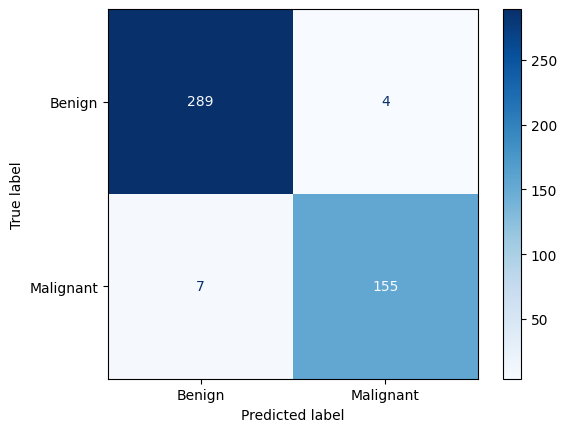

In [25]:
cross_val_confusion(voting_soft, X_train_filtered_top11, y_train_filtered_top11)


In [26]:
voting_hard = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    voting='hard'
)

results_df=evaluate_models(voting_hard, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.978         0.020              0.976   
1  Filtered Features          0.971         0.017              0.965   
2   Top 11 Important          0.974         0.017              0.968   
3    Top 5 Important          0.940         0.044              0.934   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.024                  0.969                 0.042  
1             0.022                  0.944                 0.044  
2             0.019                  0.950                 0.037  
3             0.046                  0.913                 0.063

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       293
   Malignant       0.97      0.95      0.96       162

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455



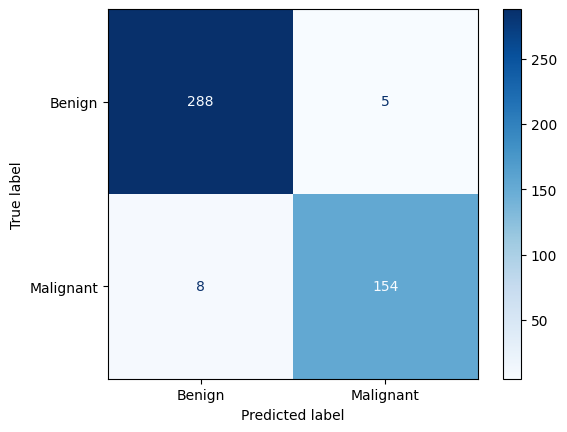

In [27]:
cross_val_confusion(voting_hard, X_train_filtered_top11, y_train_filtered_top11)

## Bagging

Vamos a aplicar bagging a árboles de decisión y regresión logísitica. Nótese, que lo aplicamos para regresión logística simplemente por una cuestión de variedad. Los modelos estables como la regresión logística no suelen beneficiarse tanto como los modelos de alta varianza (como los árboles de decisión).

A continuación citamos dos parrafos relevantes de `Elements of statistical learning`:

Not all estimators can be improved by shaking up the data like this [via bagging]. It seems that highly nonlinear estimators, such as trees, benefit the most. For bootstrapped trees, $\rho$ [the correlation of estimators] is typically small, while $\sigma^2$  [their variance] is not much larger than the variance for the original tree. On the other hand, bagging does not change linear estimates, such as the sample mean (hence its variance either); the pairwise correlation between bootstrapped means is about 50%

Note that when we bag a model, any simple structure in the model is lost. As an example, a bagged tree is no longer a tree. For interpretation of the model this is clearly a drawback. More stable procedures like nearest neighbors are typically not affected much by bagging. Unfortunately, the unstable models most helped by bagging are unstable because of the emphasis on interpretability, and this is lost in the bagging process.

In [28]:
bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Número de modelos en el ensamble
    random_state=42
)

results_df=evaluate_models(bagging_tree, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.960         0.030              0.953   
1  Filtered Features          0.949         0.024              0.940   
2   Top 11 Important          0.947         0.027              0.937   
3    Top 5 Important          0.945         0.032              0.938   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.032                  0.926                 0.047  
1             0.029                  0.907                 0.050  
2             0.032                  0.901                 0.057  
3             0.034                  0.913                 0.049

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96       293
   Malignant       0.95      0.90      0.92       162

    accuracy                           0.95       455
   macro avg       0.95      0.94      0.94       455
weighted avg       0.95      0.95      0.95       455



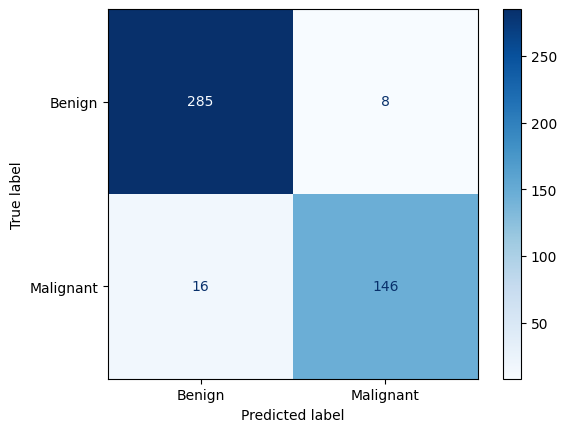

In [29]:
cross_val_confusion(bagging_tree, X_train_filtered_top11, y_train_filtered_top11)

In [30]:
bagging_LR = BaggingClassifier(
    estimator=LogisticRegression(),
    n_estimators=50,  # Número de modelos en el ensamble
    random_state=42
)

results_df=evaluate_models(bagging_LR, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.980         0.021              0.977   
1  Filtered Features          0.967         0.023              0.961   
2   Top 11 Important          0.976         0.018              0.971   
3    Top 5 Important          0.934         0.051              0.922   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.025                  0.969                 0.042  
1             0.027                  0.938                 0.048  
2             0.021                  0.957                 0.040  
3             0.057                  0.883                 0.086

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98       293
   Malignant       0.97      0.96      0.97       162

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.98      0.98      0.98       455



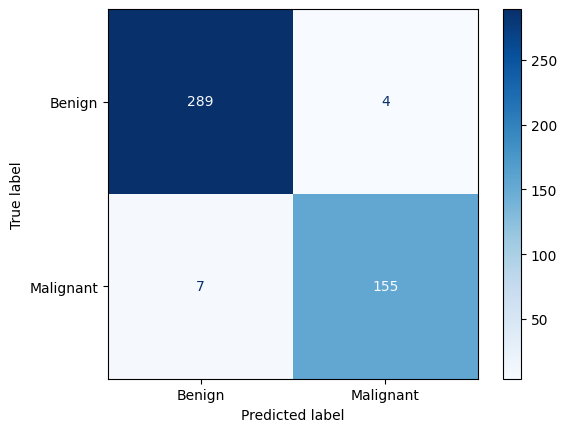

In [31]:
cross_val_confusion(bagging_LR, X_train_filtered_top11, y_train_filtered_top11)

## Random forest and extra trees

Vamos a implementar y evaluar también Random forest y Extra trees. ¿Cual es la diferencia entre estos dos modelos y bagging trees? Lo ilustramos a continuación. 

| Aspecto                    | Random Forest (Bosques Aleatorios)  | Extra Trees (Árboles Extremos)            | Bagging Trees      |
|----------------------------|-------------------------------------|-----------------------------------------|------------------------------------------|
| Modelo Base                | Árboles de Decisión                | Árboles de Decisión                     | Generalmente Árboles de Decisión         |
| Selección de Características| Subconjunto aleatorio por división| Subconjunto aleatorio por división     | Usa todas las características por división |
| Criterio de División       | Impureza Gini o Entropía           | Divisiones aleatorias                  | Impureza Gini, Entropía u otros           |
| Correlación entre Árboles   | Media                              | Baja (más aleatoriedad)                | Alta (si no se seleccionan características aleatorias) |
| Reducción de Varianza       | Alta (promedio del ensamble)      | Alta (promedio del ensamble)           | Alta (promedio del ensamble)            |
| Sesgo (Bias)                | Bajo a Medio                      | Más alto (debido a la aleatoriedad)    | Bajo a Medio                             |
| Tendencia a Sobreajuste     | Baja                              | Baja                                    | Puede ser alta si los modelos base sobreajustan |
| Robustez al Ruido           | Alta                              | Alta                                    | Media a Alta                            |


Hay un pequeño detalle que debemos tratar: Vamos a evaluar el bosque aleatorio usando validación cruzada. En realidad este paso no es necesario, es más eficiente computacionalmente evaluar el bosque aleatorio usando muestras out-of-bag. Sin embargo, como en nuestra tarea se nos pide evaluar varios modelos, he decidido estandarizar el proceso para poder reutilizar la mayor cantidad de código posible.

In [32]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

results_df=evaluate_models(rf, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.963         0.028              0.955   
1  Filtered Features          0.963         0.017              0.956   
2   Top 11 Important          0.960         0.026              0.954   
3    Top 5 Important          0.949         0.037              0.943   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.030                  0.932                 0.044  
1             0.021                  0.932                 0.043  
2             0.028                  0.932                 0.043  
3             0.039                  0.919                 0.056

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97       293
   Malignant       0.96      0.93      0.94       162

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.96       455
weighted avg       0.96      0.96      0.96       455



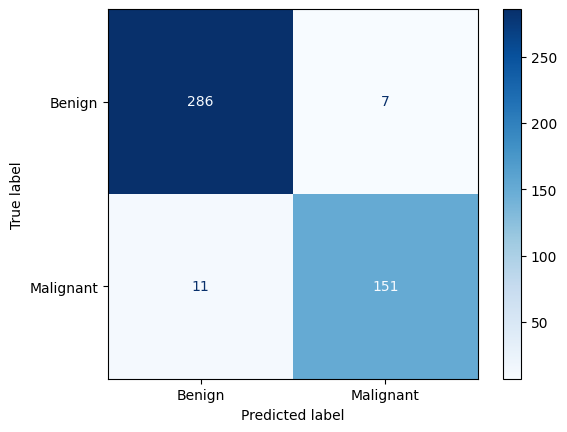

In [33]:
cross_val_confusion(rf, X_train_filtered_top11, y_train_filtered_top11)

In [34]:
et = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

results_df=evaluate_models(et, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.976         0.027              0.970   
1  Filtered Features          0.973         0.026              0.968   
2   Top 11 Important          0.971         0.026              0.966   
3    Top 5 Important          0.945         0.033              0.938   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.033                  0.951                 0.054  
1             0.030                  0.950                 0.047  
2             0.029                  0.950                 0.047  
3             0.034                  0.913                 0.049

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       293
   Malignant       0.97      0.95      0.96       162

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455



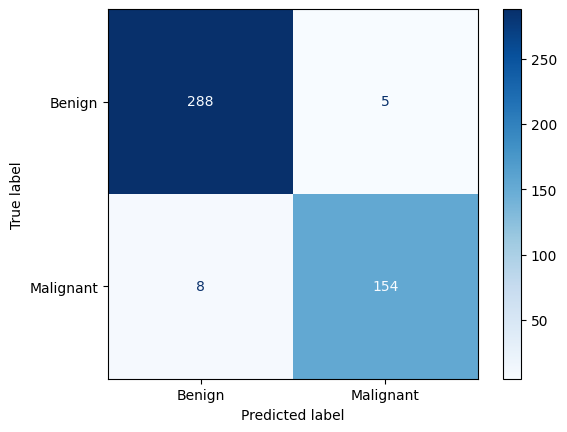

In [35]:
cross_val_confusion(et, X_train_filtered_top11, y_train_filtered_top11)

## Boosting

Mientras que *Bagging*, *Random Forest* y *Extra Trees* comparten una estrategia común de reducir la **varianza** al promediar estimadores independientes, el *Boosting* sigue un enfoque diferente orientado a **reducir el sesgo**.

En *Boosting*, los estimadores no se construyen de manera independiente, sino en **serie**. Cada nuevo estimador se entrena para corregir los errores de los anteriores, lo que permite un aprendizaje más refinado y preciso.

### Principales estrategias de Boosting

1. **AdaBoost (Adaptive Boosting):**
   - Utiliza pesos sobre las muestras para darles prioridad.  
   - Cuando un estimador comete errores clasificando una muestra, su peso se incrementa para incentivar al siguiente estimador a clasificarla correctamente.  
   - Cada estimador construido también tiene su propio peso.  
   - Al final del proceso se toma una **media ponderada** para la decisión final.  
   - Ventaja: Simple de implementar y funciona bien con modelos débiles.  
   - Desventaja: Sensible al ruido y puede sobreajustar si se permite entrenar demasiados clasificadores débiles.  

2. **Gradient Boosting / Extreme Gradient Boosting (XGBoost):**
   - Esta técnica se basa en el **descenso del gradiente**, un método comúnmente usado en redes neuronales.  
   - La idea principal es ajustar un nuevo árbol de decisión a los **pseudo-residuos** (errores cometidos por el modelo en el paso anterior).  
   - Los pseudo-residuos se calculan a partir del **gradiente de la función de pérdida**, que mide qué tan lejos está la predicción actual del valor objetivo.  
   - Se aplica una **tasa de aprendizaje** para controlar el aporte de cada nuevo árbol al modelo global.  
   - **XGBoost** es una implementación optimizada de Gradient Boosting que incluye:
     - Poda de árboles para evitar sobreajuste.
     - Penalizaciones $L^1$ y $L^2$ para mejorar la generalización.  
   - Ventaja: Alto rendimiento en tareas de clasificación y regresión, con gran capacidad de ajuste.  
   - Desventaja: Requiere más tiempo de entrenamiento y es más difícil de paralelizar que técnicas como *Random Forest*.  

In [36]:
xgb_tree = XGBClassifier(eval_metric='logloss', n_jobs=-1)

results_df=evaluate_models(xgb_tree, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.963         0.031              0.956   
1  Filtered Features          0.969         0.020              0.963   
2   Top 11 Important          0.971         0.020              0.966   
3    Top 5 Important          0.947         0.018              0.937   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.036                  0.932                 0.057  
1             0.026                  0.944                 0.052  
2             0.025                  0.950                 0.047  
3             0.020                  0.901                 0.041

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       293
   Malignant       0.97      0.95      0.96       162

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455



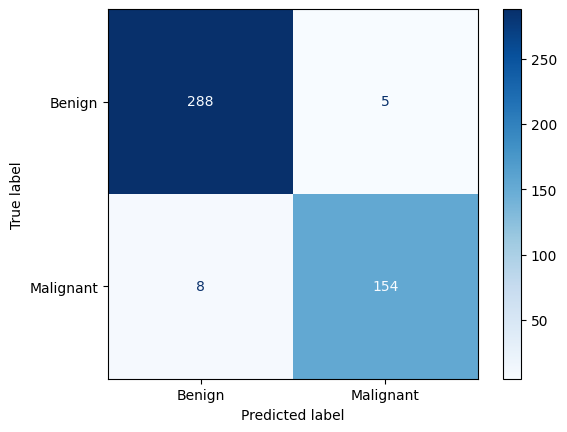

In [37]:
cross_val_confusion(xgb_tree, X_train_filtered_top11, y_train_filtered_top11)

In [38]:
logistic_base = LogisticRegression()

adaboost_logistic = AdaBoostClassifier(
    estimator=logistic_base,
    n_estimators=50,
    algorithm="SAMME.R",
    random_state=42
)

results_df=evaluate_models(adaboost_logistic, datasets, scoring=scoring)
results_df


Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.976         0.023              0.973   
1  Filtered Features          0.967         0.023              0.961   
2   Top 11 Important          0.978         0.020              0.974   
3    Top 5 Important          0.927         0.044              0.912   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.026                  0.963                 0.041  
1             0.028                  0.938                 0.048  
2             0.023                  0.963                 0.041  
3             0.053                  0.858                 0.088

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98       293
   Malignant       0.97      0.96      0.97       162

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



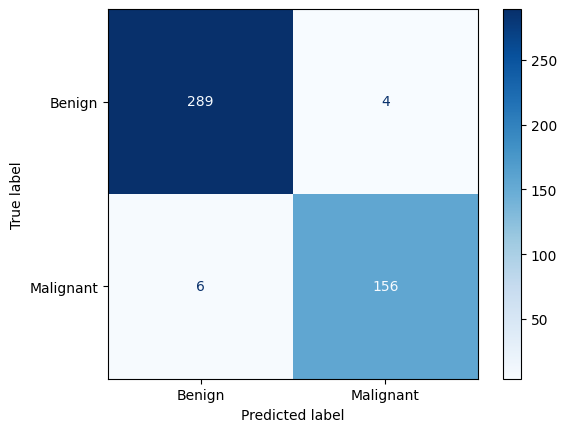

In [39]:
cross_val_confusion(adaboost_logistic, X_train_filtered_top11, y_train_filtered_top11)

## Staking

Los modelos de *Stacking* son una técnica de *Ensemble Learning* que combina varios clasificadores base con la esperanza de que cada uno compense las debilidades de los demás. La predicción final se realiza mediante un modelo adicional llamado **metalearner**, que aprende a optimizar las predicciones combinando de manera inteligente las salidas de los modelos base.

Existen dos estrategias principales para entrenar el metalearner:

1. **Utilizar únicamente las predicciones de los modelos base:**  
   El metalearner se entrena usando como entrada las predicciones generadas por los clasificadores base. Este enfoque se utiliza generalmente cuando los modelos base son suficientemente diversos o cuando se busca simplificar el proceso de combinación.

2. **Incorporar también los datos originales:**  
   Además de las predicciones de los clasificadores base, se le proporciona al metalearner los datos originales. Esto permite al metalearner identificar patrones adicionales o ajustar su ponderación según características específicas de los datos.

El principal beneficio del *Stacking* es que permite combinar modelos muy diferentes (e.g., árboles de decisión, redes neuronales, regresiones lineales) para mejorar la generalización. Por ejemplo, un *metalearner* puede aprender que un modelo basado en árboles funciona mejor en regiones no lineales, mientras que un modelo lineal se desempeña mejor en áreas con relaciones más simples.

In [40]:
stack1 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

results_df=evaluate_models(stack1, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.967         0.021              0.960   
1  Filtered Features          0.952         0.024              0.945   
2   Top 11 Important          0.956         0.022              0.948   
3    Top 5 Important          0.943         0.027              0.935   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.021                  0.938                 0.028  
1             0.031                  0.920                 0.067  
2             0.028                  0.919                 0.056  
3             0.030                  0.907                 0.050

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97       293
   Malignant       0.96      0.92      0.94       162

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.95       455
weighted avg       0.96      0.96      0.96       455



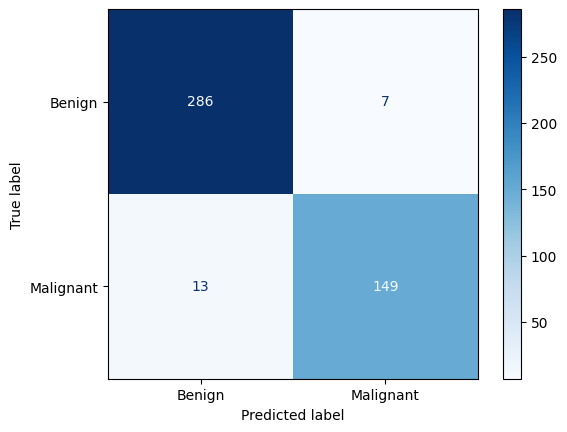

In [41]:
cross_val_confusion(stack1, X_train_filtered_top11, y_train_filtered_top11)

In [42]:
stack2 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('logreg', LogisticRegression(max_iter=1000)),
        ('et', ExtraTreesClassifier(n_estimators=100, random_state=42))
    ],
    final_estimator=RidgeClassifier(),
    cv=5
)

results_df=evaluate_models(stack2, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.973         0.022              0.970   
1  Filtered Features          0.974         0.019              0.969   
2   Top 11 Important          0.976         0.018              0.971   
3    Top 5 Important          0.947         0.033              0.942   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.027                  0.957                 0.049  
1             0.022                  0.951                 0.037  
2             0.021                  0.957                 0.040  
3             0.034                  0.926                 0.046

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98       293
   Malignant       0.97      0.96      0.97       162

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.98      0.98      0.98       455



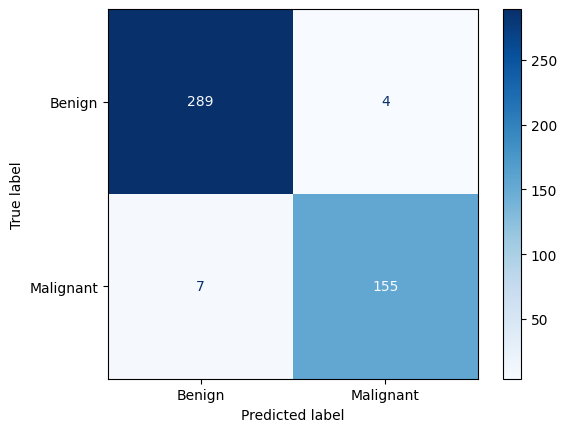

In [43]:
cross_val_confusion(stack2, X_train_filtered_top11, y_train_filtered_top11)

In [44]:
stack3 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('gb', GradientBoostingClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
results_df=evaluate_models(stack3, datasets, scoring=scoring)
results_df

Dataset  accuracy Mean  accuracy Std  recall_macro Mean  \
0       All Features          0.965         0.023              0.959   
1  Filtered Features          0.949         0.026              0.941   
2   Top 11 Important          0.952         0.024              0.943   
3    Top 5 Important          0.945         0.023              0.938   

   recall_macro Std  malignant_recall Mean  malignant_recall Std  
0             0.022                  0.938                 0.028  
1             0.033                  0.913                 0.063  
2             0.028                  0.913                 0.049  
3             0.025                  0.913                 0.049

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.98      0.96       293
   Malignant       0.95      0.91      0.93       162

    accuracy                           0.95       455
   macro avg       0.95      0.94      0.95       455
weighted avg       0.95      0.95      0.95       455



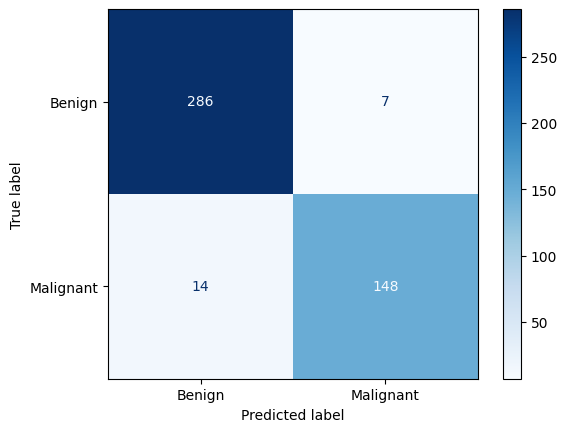

In [45]:
cross_val_confusion(stack3, X_train_filtered_top11, y_train_filtered_top11)

## Resumen de los modelos

A continuación hacemos un resumen de los resultados obtenidos por los diferentes modelos en los distintos conjuntos de datos. 

In [46]:
models_dict={'Voting_Hard':voting_hard, 'Voting_Soft': voting_soft, 
             'Bagging_Trees':bagging_tree, 'Baggin_Logistic':bagging_LR, 
             'Random_Forest': rf, 'Extra_Trees':et, 
             'Boosting_Trees': xgb_tree, 'Boosting_logistic':adaboost_logistic,
             'RF+GB->LR':stack1, 'RF+LR+ET->Ridge':stack2, 'RF+ADA+GB->LR':stack3}

datasets = {
    "All Features": (X_train, y_train),
    "Filtered Features": (X_train_filtered, y_train_filtered),
    "Top 11 Important": (X_train_filtered_top11, y_train_filtered_top11),
    "Top 5 Important": (X_train_filtered_top5, y_train_filtered_top5)
}


scoring = {
    'accuracy': 'accuracy',
    'recall_macro': 'recall_macro',
    'malignant_recall': malignant_recall
}

In [47]:
evaluate_multiple_models(models_dict, datasets, scoring=scoring, ordering='malignant_recall')

accuracy Mean  recall_macro Mean  \
Dataset           Model                                                 
All Features      Voting_Hard                0.980              0.979   
                  Voting_Soft                0.980              0.978   
                  Baggin_Logistic            0.980              0.977   
                  Boosting_logistic          0.976              0.973   
                  RF+LR+ET->Ridge            0.973              0.970   
                  Extra_Trees                0.976              0.970   
                  RF+ADA+GB->LR              0.967              0.962   
                  RF+GB->LR                  0.967              0.960   
                  Boosting_Trees             0.963              0.956   
                  Random_Forest              0.963              0.955   
                  Bagging_Trees              0.960              0.953   
Filtered Features Voting_Soft                0.976              0.971   
                  RF+LR+ET->Ridge            0.974              0.969   
                  Extra_Trees                0.973              0.968   
                  Voting_Hard                0.971              0.965   
                  Boosting_Trees             0.969              0.963   
                  Baggin_Logistic            0.967              0.961   
                  Boosting_logistic          0.967              0.961   
                  Random_Forest              0.963              0.956   
                  RF+GB->LR                  0.952              0.945   
                  RF+ADA+GB->LR              0.949              0.943   
                  Bagging_Trees              0.949              0.940   
Top 11 Important  Boosting_logistic          0.978              0.974   
                  Voting_Hard                0.976              0.971   
                  Voting_Soft                0.976              0.971   
                  Baggin_Logistic            0.976              0.971   
                  RF+LR+ET->Ridge            0.976              0.971   
                  Extra_Trees                0.971              0.966   
                  Boosting_Trees             0.971              0.966   
                  Random_Forest              0.960              0.954   
                  RF+GB->LR                  0.956              0.948   
                  RF+ADA+GB->LR              0.954              0.946   
                  Bagging_Trees              0.947              0.937   
Top 5 Important   Voting_Soft                0.945              0.941   
                  RF+LR+ET->Ridge            0.947              0.942   
                  Random_Forest              0.949              0.943   
                  Voting_Hard                0.943              0.936   
                  Bagging_Trees              0.945              0.938   
                  Extra_Trees                0.945              0.938   
                  RF+GB->LR                  0.943              0.935   
                  RF+ADA+GB->LR              0.943              0.935   
                  Boosting_Trees             0.947              0.937   
                  Baggin_Logistic            0.934              0.922   
                  Boosting_logistic          0.927              0.912   

                                     malignant_recall Mean  
Dataset           Model                                     
All Features      Voting_Hard                        0.975  
                  Voting_Soft                        0.969  
                  Baggin_Logistic                    0.969  
                  Boosting_logistic                  0.963  
                  RF+LR+ET->Ridge                    0.957  
                  Extra_Trees                        0.951  
                  RF+ADA+GB->LR                      0.944  
                  RF+GB->LR                          0.938  
                  Boosting_Trees                     0.932  
       

A partir de los resultados anteriores, podemos observar que la mayoría de los modelos mantienen o incluso mejoran su desempeño al reducir el número de características redundantes. Sin embargo, este beneficio se desvanece cuando eliminamos demasiadas variables, lo que sugiere la existencia de un **punto óptimo** en el cual se retiene la mayor parte de la información relevante mientras se minimizan las colinealidades.

El conjunto de datos que incluye las **11 variables más importantes** (seleccionadas con *Random Forest* después de filtrar aquellas con alta correlación) proporciona el mejor rendimiento general en todas las métricas evaluadas. 

En cambio, cuando se reduce el número de variables a solo **5 características**, el desempeño de los modelos se deteriora notablemente. Esto indica que al eliminar variables relevantes en exceso, se pierde información esencial para las predicciones, afectando negativamente la generalización.

Mostramos a continuación las matrices de confusión construidas con validación cruzada (sobre el conjunto de entrenamiento) de os diferentes modelos.

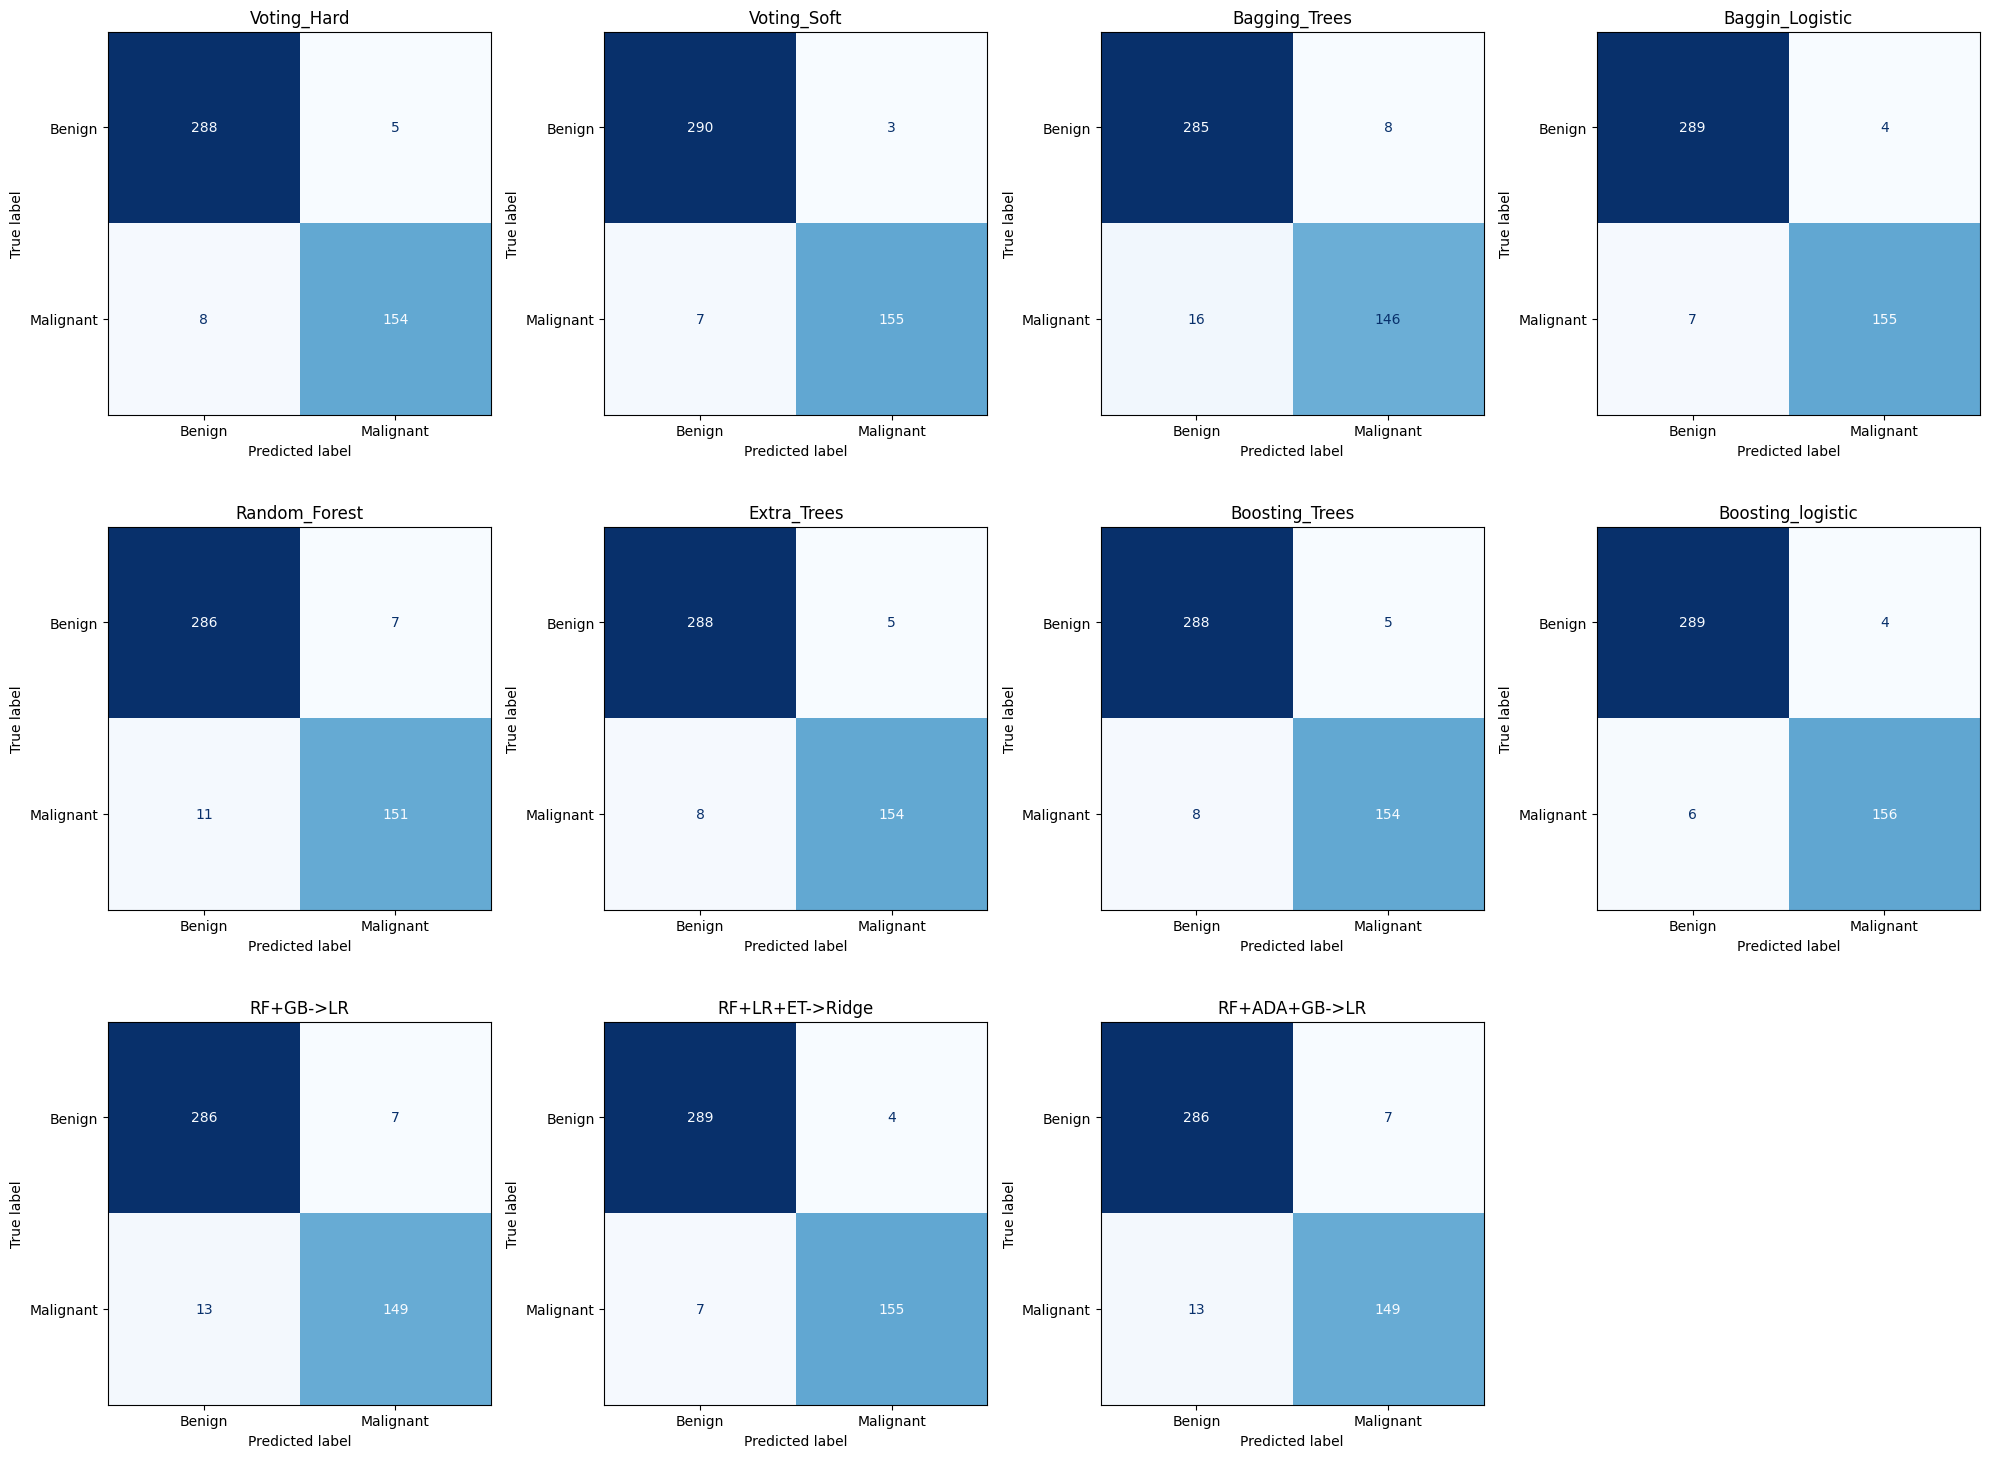

In [48]:
multiple_cross_val_confusions(models_dict, X_train_filtered_top11, y_train_filtered_top11)

# Afinación de hiperparámetros

Pasamos ahora a afinar los hiperparámetros de los mejores 6 modelos encontrados en el paso anterior. La lista de modelos es la siguiente:



Para entrenarlos, vamos a usar la búsqueda aleatoria con `RandomizedSearchCV`.

In [49]:
X_test_filtered_top11=df_test_scaled[top_11_imp_features]
y_test_filtered_top11=df_test_scaled[target]

scoring = make_scorer(recall_score, pos_label=1)

## Voting

In [50]:
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))
]
voting_soft = VotingClassifier(estimators=estimators, voting='soft')


param_grid = {
    'lr__C': np.logspace(-4, 4, 10),
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [None, 10, 20],
    'svc__C': np.logspace(-3, 2, 6),
    'svc__gamma': ['scale', 'auto']
}


RS_results=perform_random_search(voting_soft, param_grid, X_train_filtered_top11, y_train_filtered_top11,scoring)



Performing RandomizedSearchCV for VotingClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for VotingClassifier: 0.975
Best Parameters for VotingClassifier: {'svc__gamma': 'auto', 'svc__C': 1.0, 'rf__n_estimators': 200, 'rf__max_depth': None, 'lr__C': 1291.5496650148827}


In [51]:
best_params = RS_results['best_params']

# Call the function with the instantiated model
model, report = evaluate_final_model(
    model=voting_soft,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.94      0.97        50

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Bagging

In [52]:
bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier()
)

param_grid = {
    'n_estimators': [10, 50, 100, 200],                           
    'estimator__criterion': ['gini', 'entropy'],   
    'estimator__max_depth': [None, 5, 10, 20],                    
    'estimator__min_samples_split': [2, 5, 10],                   
    'estimator__min_samples_leaf': [1, 2, 4],               
    'estimator__max_features': [None, 'sqrt', 'log2'],                                              
}

RS_results=perform_random_search(bagging_tree, param_grid, X_train_filtered_top11, y_train_filtered_top11,scoring)


Performing RandomizedSearchCV for BaggingClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for BaggingClassifier: 0.9507352941176471
Best Parameters for BaggingClassifier: {'n_estimators': 100, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'log2', 'estimator__max_depth': 20, 'estimator__criterion': 'gini'}


In [53]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=bagging_tree,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        64
           1       1.00      0.92      0.96        50

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [54]:
bagging_LR = BaggingClassifier(
    estimator=LogisticRegression(),
)

param_grid = {
    'n_estimators': [10, 50, 100, 200],                             # Number of models in the ensemble
    'estimator__C': np.logspace(-4, 4, 10),                         # Regularization strength for Logistic Regression
}

RS_results=perform_random_search(bagging_LR, param_grid, X_train_filtered_top11, y_train_filtered_top11,scoring )


Performing RandomizedSearchCV for BaggingClassifier...

Fitting 10 folds for each of 40 candidates, totalling 400 fits

Best Score for BaggingClassifier: 0.9566176470588236
Best Parameters for BaggingClassifier: {'n_estimators': 10, 'estimator__C': 2.782559402207126}


In [55]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=bagging_LR,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.94      0.97        50

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Boosting

In [56]:
xgb_model = XGBClassifier(eval_metric='logloss', n_jobs=-1)

param_grid = {
    'n_estimators': [ 200, 500, 1000, 1500],                   # Number of boosting rounds
    'learning_rate': [0.001, 0.01, 0.1, 0.2],             # Step size shrinkage to prevent overfitting
    'max_depth': [1,2,3, 5, 10],                              # Maximum depth of a tree
    'subsample': [0.7, 0.8, 1.0],                        # Fraction of samples used for training each tree
    'colsample_bytree': [0.7, 0.8, 1.0],                 # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.5, 1],                           # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1, 1],                      # L1 regularization term on weights
    'reg_lambda': [1, 0.1, 0.01, 0]                      # L2 regularization term on weights
}

RS_results = perform_random_search(xgb_model, param_grid, X_train_filtered_top11, y_train_filtered_top11, scoring, n_iter=100)



Performing RandomizedSearchCV for XGBClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for XGBClassifier: 0.9625
Best Parameters for XGBClassifier: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [57]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=xgb_model,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.94      0.97        50

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [58]:
xgb_model = XGBClassifier(eval_metric='logloss', n_jobs=-1)

param_grid = {
    'max_depth': [1,2, 3],
    'learning_rate': [ 0.01, 0.1],
    'n_estimators': [300, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.5, 1],                           # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.1, 1],                      # L1 regularization term on weights
    'reg_lambda': [1, 0.1, 0]  
}

scoring = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_filtered_top11, y_train_filtered_top11)

# Best model
best_params = grid_search.best_params_
cv_score=grid_search.best_score_  

print(f"Best Params: {grid_search.best_params_}")
print(f"Cross-Validated score: {cv_score}")


Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Cross-Validated score: 0.95625


In [59]:
final_model = XGBClassifier(eval_metric='logloss', **best_params)
final_model.fit(X_train_filtered_top11, y_train_filtered_top11)

y_pred = final_model.predict(X_test_filtered_top11)

print(classification_report(y_test_filtered_top11, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.94      0.98      0.96        64
   Malignant       0.98      0.92      0.95        50

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.96       114
weighted avg       0.96      0.96      0.96       114



Benign recall is easier to achieve if it has more consistent features
It’s possible that:

Benign cases have more regular, well-separated features

Malignant cases are more diverse or noisy, which makes them harder to catch all the time

So your model naturally finds it easier to classify benign samples with higher recall — even while prioritizing malignant during tuning.

In [60]:
logistic_base = LogisticRegression()

adaboost_logistic = AdaBoostClassifier(
    estimator=logistic_base,
    algorithm="SAMME.R",
)

param_grid = {
    'n_estimators': [10, 50, 100, 200],                        
    'estimator__C': np.logspace(-4, 4, 10),                    
    'estimator__penalty': ['l2', 'none'],                      
    'learning_rate': [0.001, 0.01, 0.1, 1.0]                  
}

RS_results = perform_random_search(adaboost_logistic, param_grid, X_train_filtered_top11, y_train_filtered_top11, scoring)



Performing RandomizedSearchCV for AdaBoostClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for AdaBoostClassifier: 0.9625
Best Parameters for AdaBoostClassifier: {'n_estimators': 200, 'learning_rate': 0.1, 'estimator__penalty': 'l2', 'estimator__C': 2.782559402207126}


In [61]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=adaboost_logistic,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       1.00      0.94      0.97        50

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Stacking

In [ ]:
stack1 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('gb', GradientBoostingClassifier()),
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

param_grid = {
    'final_estimator__C': np.logspace(-4, 4, 10),                  
    'rf__n_estimators': [100, 200, 500],                           
    'rf__max_depth': [None, 10, 20],                               
    'rf__min_samples_split': [2, 5, 10],                           
    'rf__min_samples_leaf': [1, 2, 4],                             
    'gb__n_estimators': [100, 200, 500],                          
    'gb__learning_rate': [0.001, 0.01, 0.1],                      
    'gb__max_depth': [3, 5, 10],                                
    'gb__subsample': [0.5, 0.7, 1.0]                             
}

RS_results = perform_random_search(stack1, param_grid, X_train_filtered_top11, y_train_filtered_top11, scoring)



Performing RandomizedSearchCV for StackingClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for StackingClassifier: 0.96875
Best Parameters for StackingClassifier: {'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 10, 'gb__subsample': 0.7, 'gb__n_estimators': 200, 'gb__max_depth': 3, 'gb__learning_rate': 0.01, 'final_estimator__C': 166.81005372000558}


In [63]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=stack1,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.98      0.94      0.96        50

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
stack2 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('logreg', LogisticRegression(max_iter=1000)),
        ('et', ExtraTreesClassifier())
    ],
    final_estimator=RidgeClassifier(),
    cv=5
)

param_grid = {
    'final_estimator__alpha': np.logspace(-4, 4, 10),               
    'rf__n_estimators': [100, 200, 500],                            
    'rf__max_depth': [None, 10, 20],                               
    'rf__min_samples_split': [2, 5, 10],                           
    'rf__min_samples_leaf': [1, 2, 4],                           
    'et__n_estimators': [100, 200, 500],                          
    'et__max_depth': [None, 10, 20],                             
    'et__min_samples_split': [2, 5, 10],                         
    'et__min_samples_leaf': [1, 2, 4],                            
    'logreg__C': np.logspace(-4, 4, 10)                           
}

RS_results = perform_random_search(stack2, param_grid, X_train_filtered_top11, y_train_filtered_top11, scoring)



Performing RandomizedSearchCV for StackingClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for StackingClassifier: 0.9628676470588236
Best Parameters for StackingClassifier: {'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20, 'logreg__C': 10000.0, 'final_estimator__alpha': 0.0001, 'et__n_estimators': 500, 'et__min_samples_split': 5, 'et__min_samples_leaf': 2, 'et__max_depth': None}


In [65]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=stack2,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.98      0.94      0.96        50

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [66]:
stack3 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('gb', GradientBoostingClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

param_grid = {
    'final_estimator__C': np.logspace(-4, 4, 10),                  
    'rf__n_estimators': [100, 200, 500],                           
    'rf__max_depth': [None, 10, 20],                               
    'rf__min_samples_split': [2, 5, 10],                          
    'rf__min_samples_leaf': [1, 2, 4],                            
    'ada__n_estimators': [50, 100, 200],                         
    'ada__learning_rate': [0.001, 0.01, 0.1, 1.0],               
    'gb__n_estimators': [100, 200, 500],                         
    'gb__learning_rate': [0.001, 0.01, 0.1, 0.2],               
    'gb__max_depth': [3, 5, 10],                               
    'gb__subsample': [0.5, 0.7, 1.0]                           
}

RS_results = perform_random_search(stack3, param_grid, X_train_filtered_top11, y_train_filtered_top11, scoring)



Performing RandomizedSearchCV for StackingClassifier...

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Score for StackingClassifier: 0.9566176470588236
Best Parameters for StackingClassifier: {'rf__n_estimators': 100, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'gb__subsample': 0.5, 'gb__n_estimators': 500, 'gb__max_depth': 3, 'gb__learning_rate': 0.1, 'final_estimator__C': 2.782559402207126, 'ada__n_estimators': 100, 'ada__learning_rate': 0.01}


In [67]:
best_params = RS_results['best_params']

model, report = evaluate_final_model(
    model=stack3,
    best_params=best_params,
    X_train=X_train_filtered_top11,
    y_train=y_train_filtered_top11,
    X_test=X_test_filtered_top11,
    y_test=y_test_filtered_top11
)

print(report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        64
           1       1.00      0.92      0.96        50

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



# Interpretabilidad

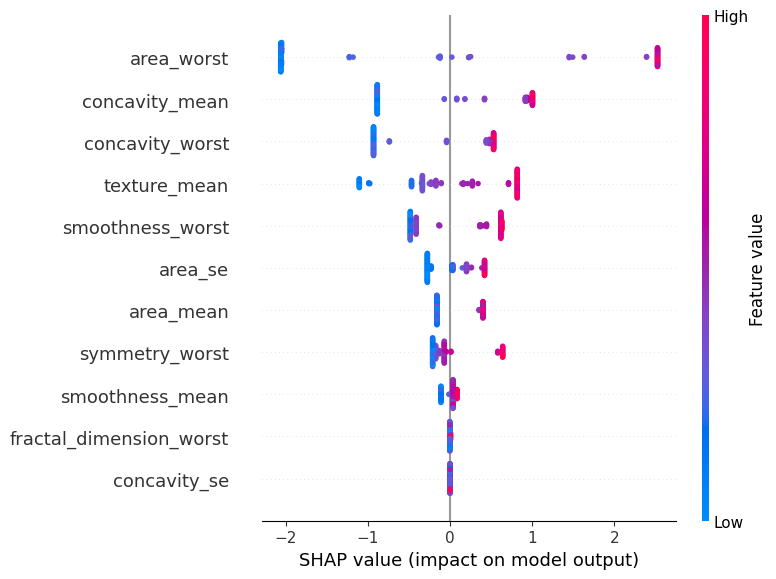

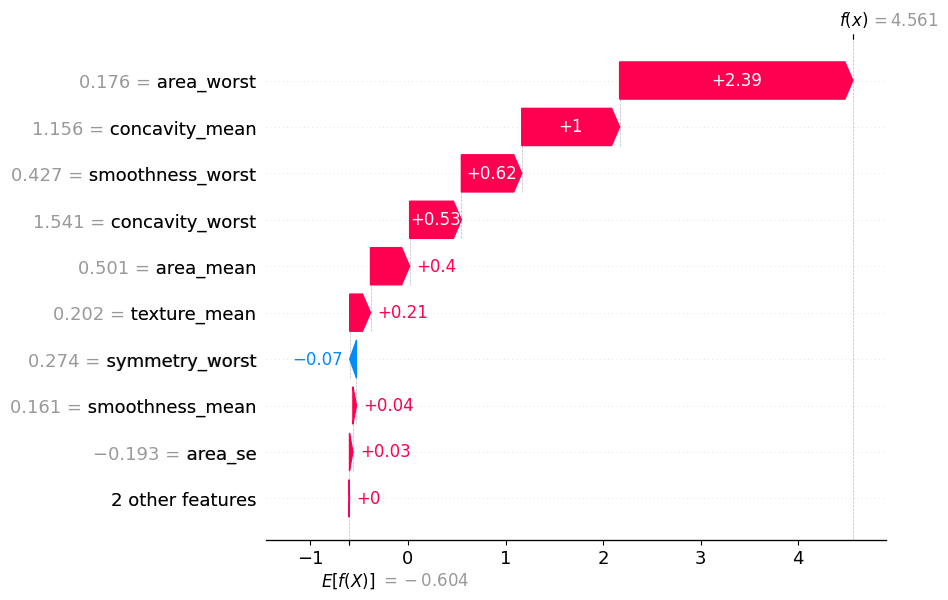

In [68]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test_filtered_top11)

# Summary plot (Global feature importance)
shap.summary_plot(shap_values, X_test_filtered_top11)

# Waterfall plot for a specific company (first instance in test set)
shap.waterfall_plot(shap_values[0])

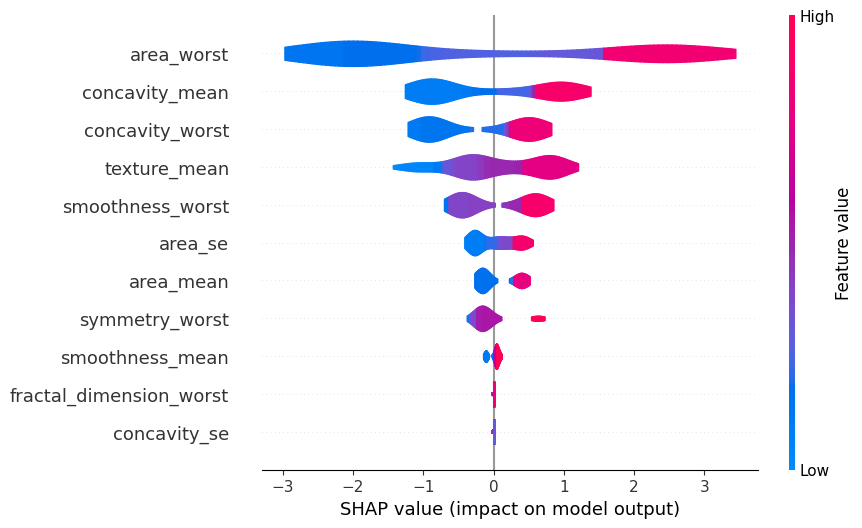

In [69]:
shap.violin_plot(shap_values, X_test_filtered_top11)

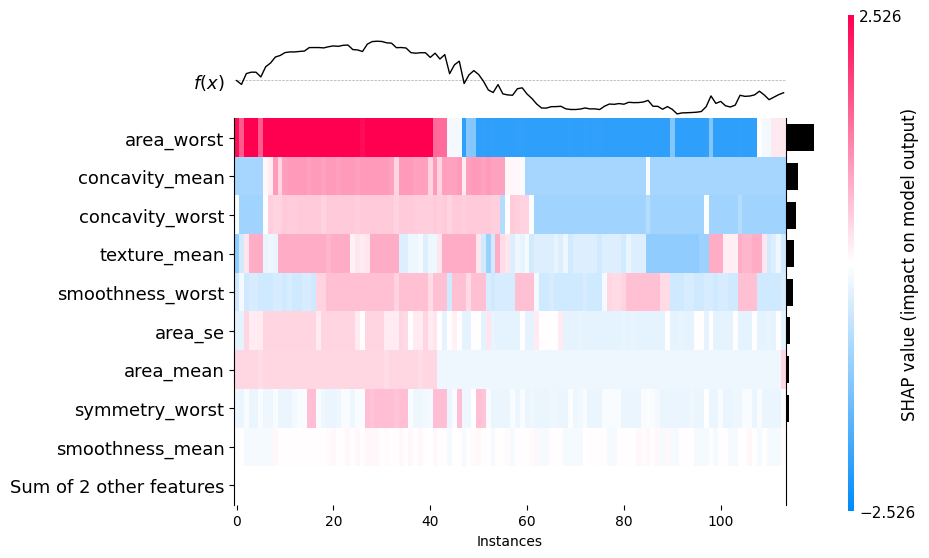

<Axes: xlabel='Instances'>

In [70]:
shap.plots.heatmap(shap_values)

In [71]:
force_plot=shap.plots.force(shap_values)
shap.save_html("shap_force_plot.html", force_plot)

print("SHAP force plot saved as 'shap_force_plot.html'. Open it in a browser.")

SHAP force plot saved as 'shap_force_plot.html'. Open it in a browser.


# Extra